In [1]:
from eigen_rootfinding.utils import condeigs
from eigen_rootfinding.polyroots import solve
from eigen_rootfinding.Multiplication import *
import eigen_rootfinding as er
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from tests.devastating_example_test_scripts import *
from tests.conditioning_ratios import *
from scipy.stats import linregress
from scipy.spatial.distance import pdist
%load_ext autoreload
%autoreload 2

Recall that the absolute condition number of a simple root $\mathbf z$ of $f:\mathbb{R}^n\mapsto\mathbb{R}^n$ is:
    $$\kappa(\mathbf z,f) = \left\lVert{Df(\mathbf z)^{-1}}\right\rVert,$$
where $Df$ is the Jacobian of $f$
and that the condition number of a simple eigenvalue $\lambda$ of matrix A with left and right eigenvectors $\mathbf u$ and $\mathbf v$, respectively, is:
    $$\kappa(\lambda,A) = \frac{\left\lVert{\mathbf u}\right\rVert \left\lVert{\mathbf v}\right\rVert}{|\mathbf u^H\mathbf v|}$$
(see Proposition 14.1 in [Bürgisser and Cucker](https://doi.org/10.1007/978-3-642-38896-5) and p.359 in [Golub and Van Loan](https://books.google.com/books/about/Matrix_Computations.html?id=X5YfsuCWpxMC)).

We refer to the following quadratic system from [Noferini and Townsend](https://doi.org/10.1137/15M1022513), as the *devastating example*:

$$
\left(
\begin{array}{c}
    p_1(x_1,\ldots,x_n)\\
    \vdots \\ 
    p_n(x_1,\ldots,x_n)\\
\end{array}
\right)
=
\left(
\begin{array}{c}
    x_1^2\\
    \vdots\\
    x_n^2\\
\end{array}
\right)
+ \varepsilon Q
\left(
\begin{array}{c}
    x_1\\
    \vdots\\
    x_n\\
\end{array}
\right)
$$
where $Q$ is any orthogonal matrix and $\varepsilon> 0$ is small. 

At $\mathbf x^*=[0,\dots,0]^\top$, the Jacobian of the devastating system is $J(\mathbf x^*)=\varepsilon Q$, so the condition number of the root at $\mathbf x^*$ is 
$||J(\mathbf x^*)^{-1}||=||\varepsilon^{-1}Q^{-1}||=\varepsilon^{-1}.$

However, the condition number of the corresponding eigenvalue of the M\"{o}ller-Stetter matrix is $\kappa(\lambda,M_{x_i}) = \Omega(\varepsilon^{-n})$, i.e., asymptotically of order at least $\varepsilon^{-n}$. This shows that the condition number of the eigenvalue may grow exponentially with dimension even though the condition number of the root is constant in dimension.

To explore the frequency of behavior like the devastating example, we define the \textit{conditioning ratio} 
for a M\"{o}ller-Stetter eigenproblem. This definition is inspired by Trefethen and Bau's analysis of the stability of Gaussian elimination (see p. 164 in [Trefethen and Bau](https://books.google.com/books/about/Numerical_Linear_Algebra.html?id=JaPtxOytY7kC)). 
We define the conditioning ratio for a M\"oller-Stetter eigenproblem for an eigenvalue $\lambda$ of a M\"oller-Stetter matrix $M_g$ corresponding to a root $z$ to be
    $$CR(\lambda,z,f,M_g) = \frac{\kappa(\lambda,M_g)}{\kappa(z,f)}$$
The base-10 logarithm of the conditioning ratio measures how many additional digits of precision may be lost when converting the root-finding problem into an eigenproblem. 

We also define the *growth rate* of the conditioning ratios of a family of problems to be the value $r$ such that the conditioning ratio is approximately $C(1+r)^n$ for some constant $C$. The growth rate can be numerically estimated via $r = b^s - 1$ where $s$ is the slope of the line of best fit to the base-$b$ logarithm of computed conditioning ratios. 

The conditioning ratio of the devastating example is $\Omega(\varepsilon^{1-n})$ with a growth rate of $r = \varepsilon^{-1}-1$, and numerical computation is consistent with these theoretical values.

In this notebook we will present the numerical experiments we performed using conditioning ratios.

# Comparing Random and Devastating Systems

Because solving high dimensional systems is very computationally intensive, we will not explicitly run those tests in this notebook. Instead, the data will be loaded in below. To see the scripts used to run this experiment, see the `if __name__ == "__main__":` portion of the `tests/conditioning_ratios.py` file.

### random systems

In [109]:
folder = 'tests/conditioning_ratios/rand/newton/'
rand_polished = {d:np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)
                      for d in range(2,5)}
for d in rand_polished.keys():
    print(rand_polished[d].shape)

(300, 2, 4)
(300, 3, 8)
(300, 4, 16)


### devastating systems

In [110]:
folder = 'tests/conditioning_ratios/dev/newton/'
dev_polished = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,5)}
for d in dev_polished.keys():
    print(dev_polished[d].shape)  

(50, 2)
(50, 3)
(50, 4)


Random Systems
Slope: 0.00389756320252187 
Intercept: 0.20886998393423672 
Exponential Growth Rate: 0.009014862233132748

Devastating Systems, $\epsilon=10^{-1}$
Slope: 0.9995649699490553 
Intercept: -0.9966409088368495 
Exponential Growth Rate: 8.989988078173619



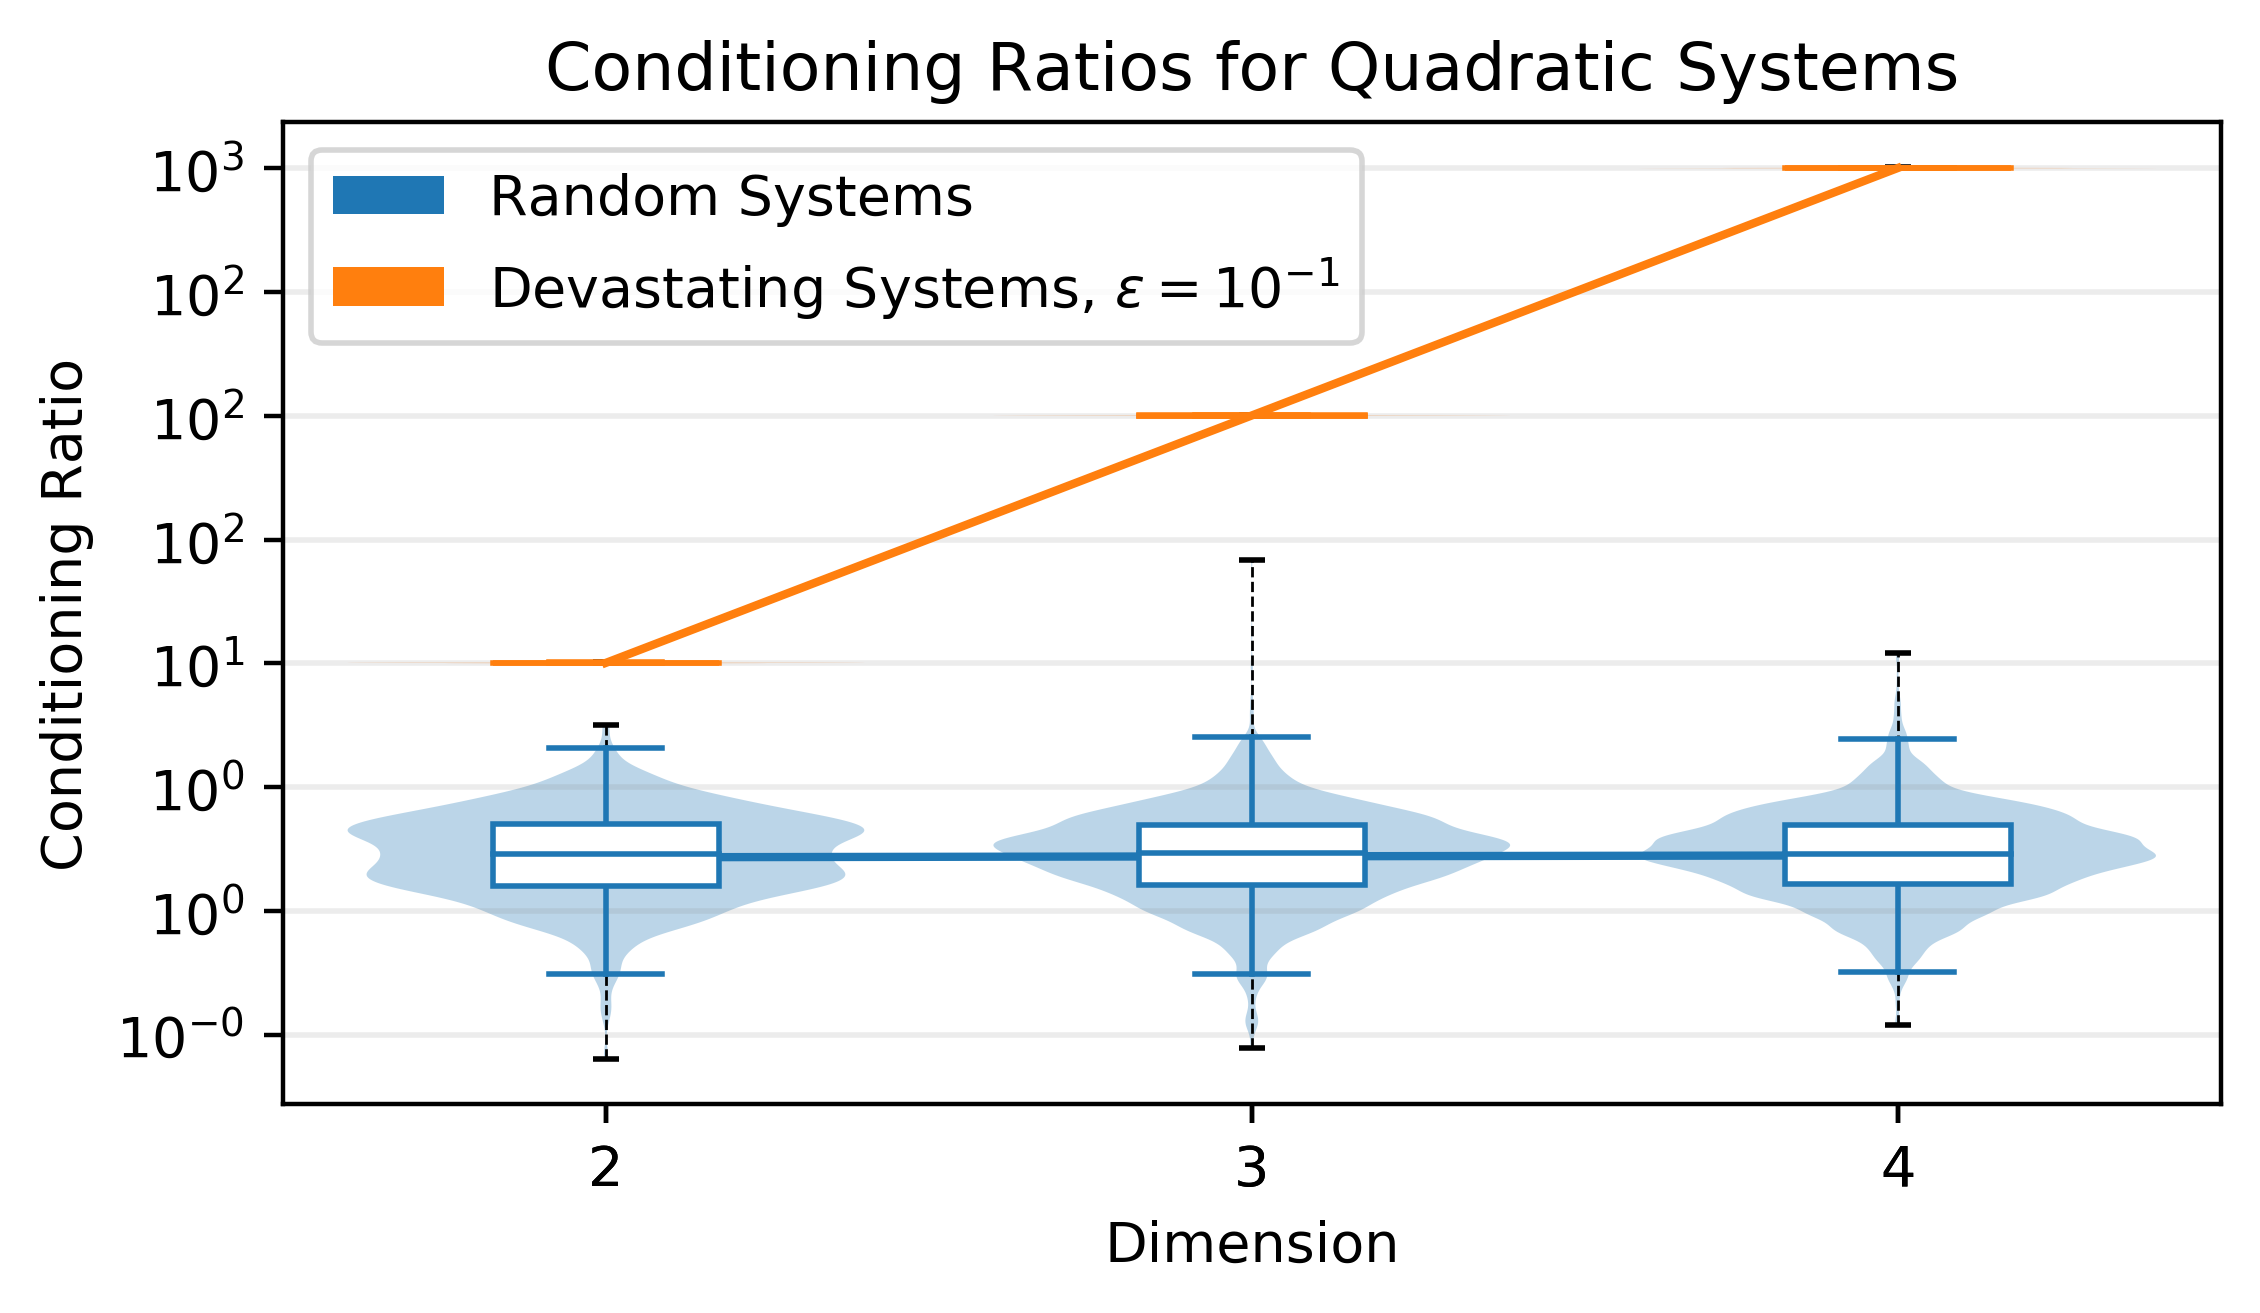

In [111]:
plot([rand_polished,dev_polished],
     ['Random Systems',r'Devastating Systems, $\epsilon=10^{-1}$'],
     figsize=(6.25,3.25), filename='rand_dev', title='Conditioning Ratios for Quadratic Systems')

### comparison to without polishing

folder = 'tests/conditioning_ratios/rand/nopol/'
normal_masks_nopol = {d:~np.load(folder+f'dim{d}/not_full_roots_deg2.npy') for d in range(3,5)}
normal_masks_nopol[2] = np.ones(300,dtype=bool)
rand_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2_res.npy',
                                allow_pickle=True)[normal_masks_nopol[d]])
                      for d in range(2,5)}
for d in rand_nopol.keys():
    print(rand_nopol[d].shape)

folder = 'tests/conditioning_ratios/dev/nopol/'
dev_nopol = {d:np.stack(np.load(folder+f'dim{d}/deg2.npy',
                                allow_pickle=True))
                      for d in range(2,5)}
for d in dev_nopol.keys():
    print(dev_nopol[d].shape)  

summary: it was practically the same, but polishing the denominator (root) did seem to make it ever so slightly more accurate, so let's go with that.

# perturbing the devastating example

In [27]:
dev_1 = devastating_conditioning_ratios([2,3,4,5],.1,'power',newton=False,save=False,detailed=False)

In [28]:
dev_2 = devastating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False)

In [29]:
dev_2_delta_1 = devastating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.1)

In [30]:
dev_2_delta_2 = devastating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.01)


In [31]:
dev_2_delta_3 = devastating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.001)

In [32]:
dev_2_delta_4 = devastating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.0001)

In [33]:
dev_2_delta_5 = devastating_conditioning_ratios([2,3,4,5],.01,'power',newton=False,save=False,delta=.00001)

devastating Systems, $\epsilon=.01$
Slope: 1.9999992674663203 
Intercept: -1.9999754282694306 
Exponential Growth Rate: 98.99983132802915

Perturbed devastating Systems, $\epsilon=.01, \delta=.00001$
Slope: 1.993731058425459 
Intercept: -2.0362173928208405 
Exponential Growth Rate: 97.56689104204969

Perturbed devastating Systems, $\epsilon=.01, \delta=.0001$
Slope: 1.741003395634404 
Intercept: -1.7957199962783799 
Exponential Growth Rate: 54.081200304284344

Perturbed devastating Systems, $\epsilon=.01, \delta=.001$
Slope: 1.29853652887252 
Intercept: -1.3961163092855222 
Exponential Growth Rate: 18.885500619735982

Perturbed devastating Systems, $\epsilon=.01, \delta=.01$
Slope: 0.8021768824007329 
Intercept: -0.8951716367872398 
Exponential Growth Rate: 5.3412793059111054

Perturbed devastating Systems, $\epsilon=.01, \delta=.1$
Slope: 0.2343819610344608 
Intercept: -0.18243976176614596 
Exponential Growth Rate: 0.7154653922437229



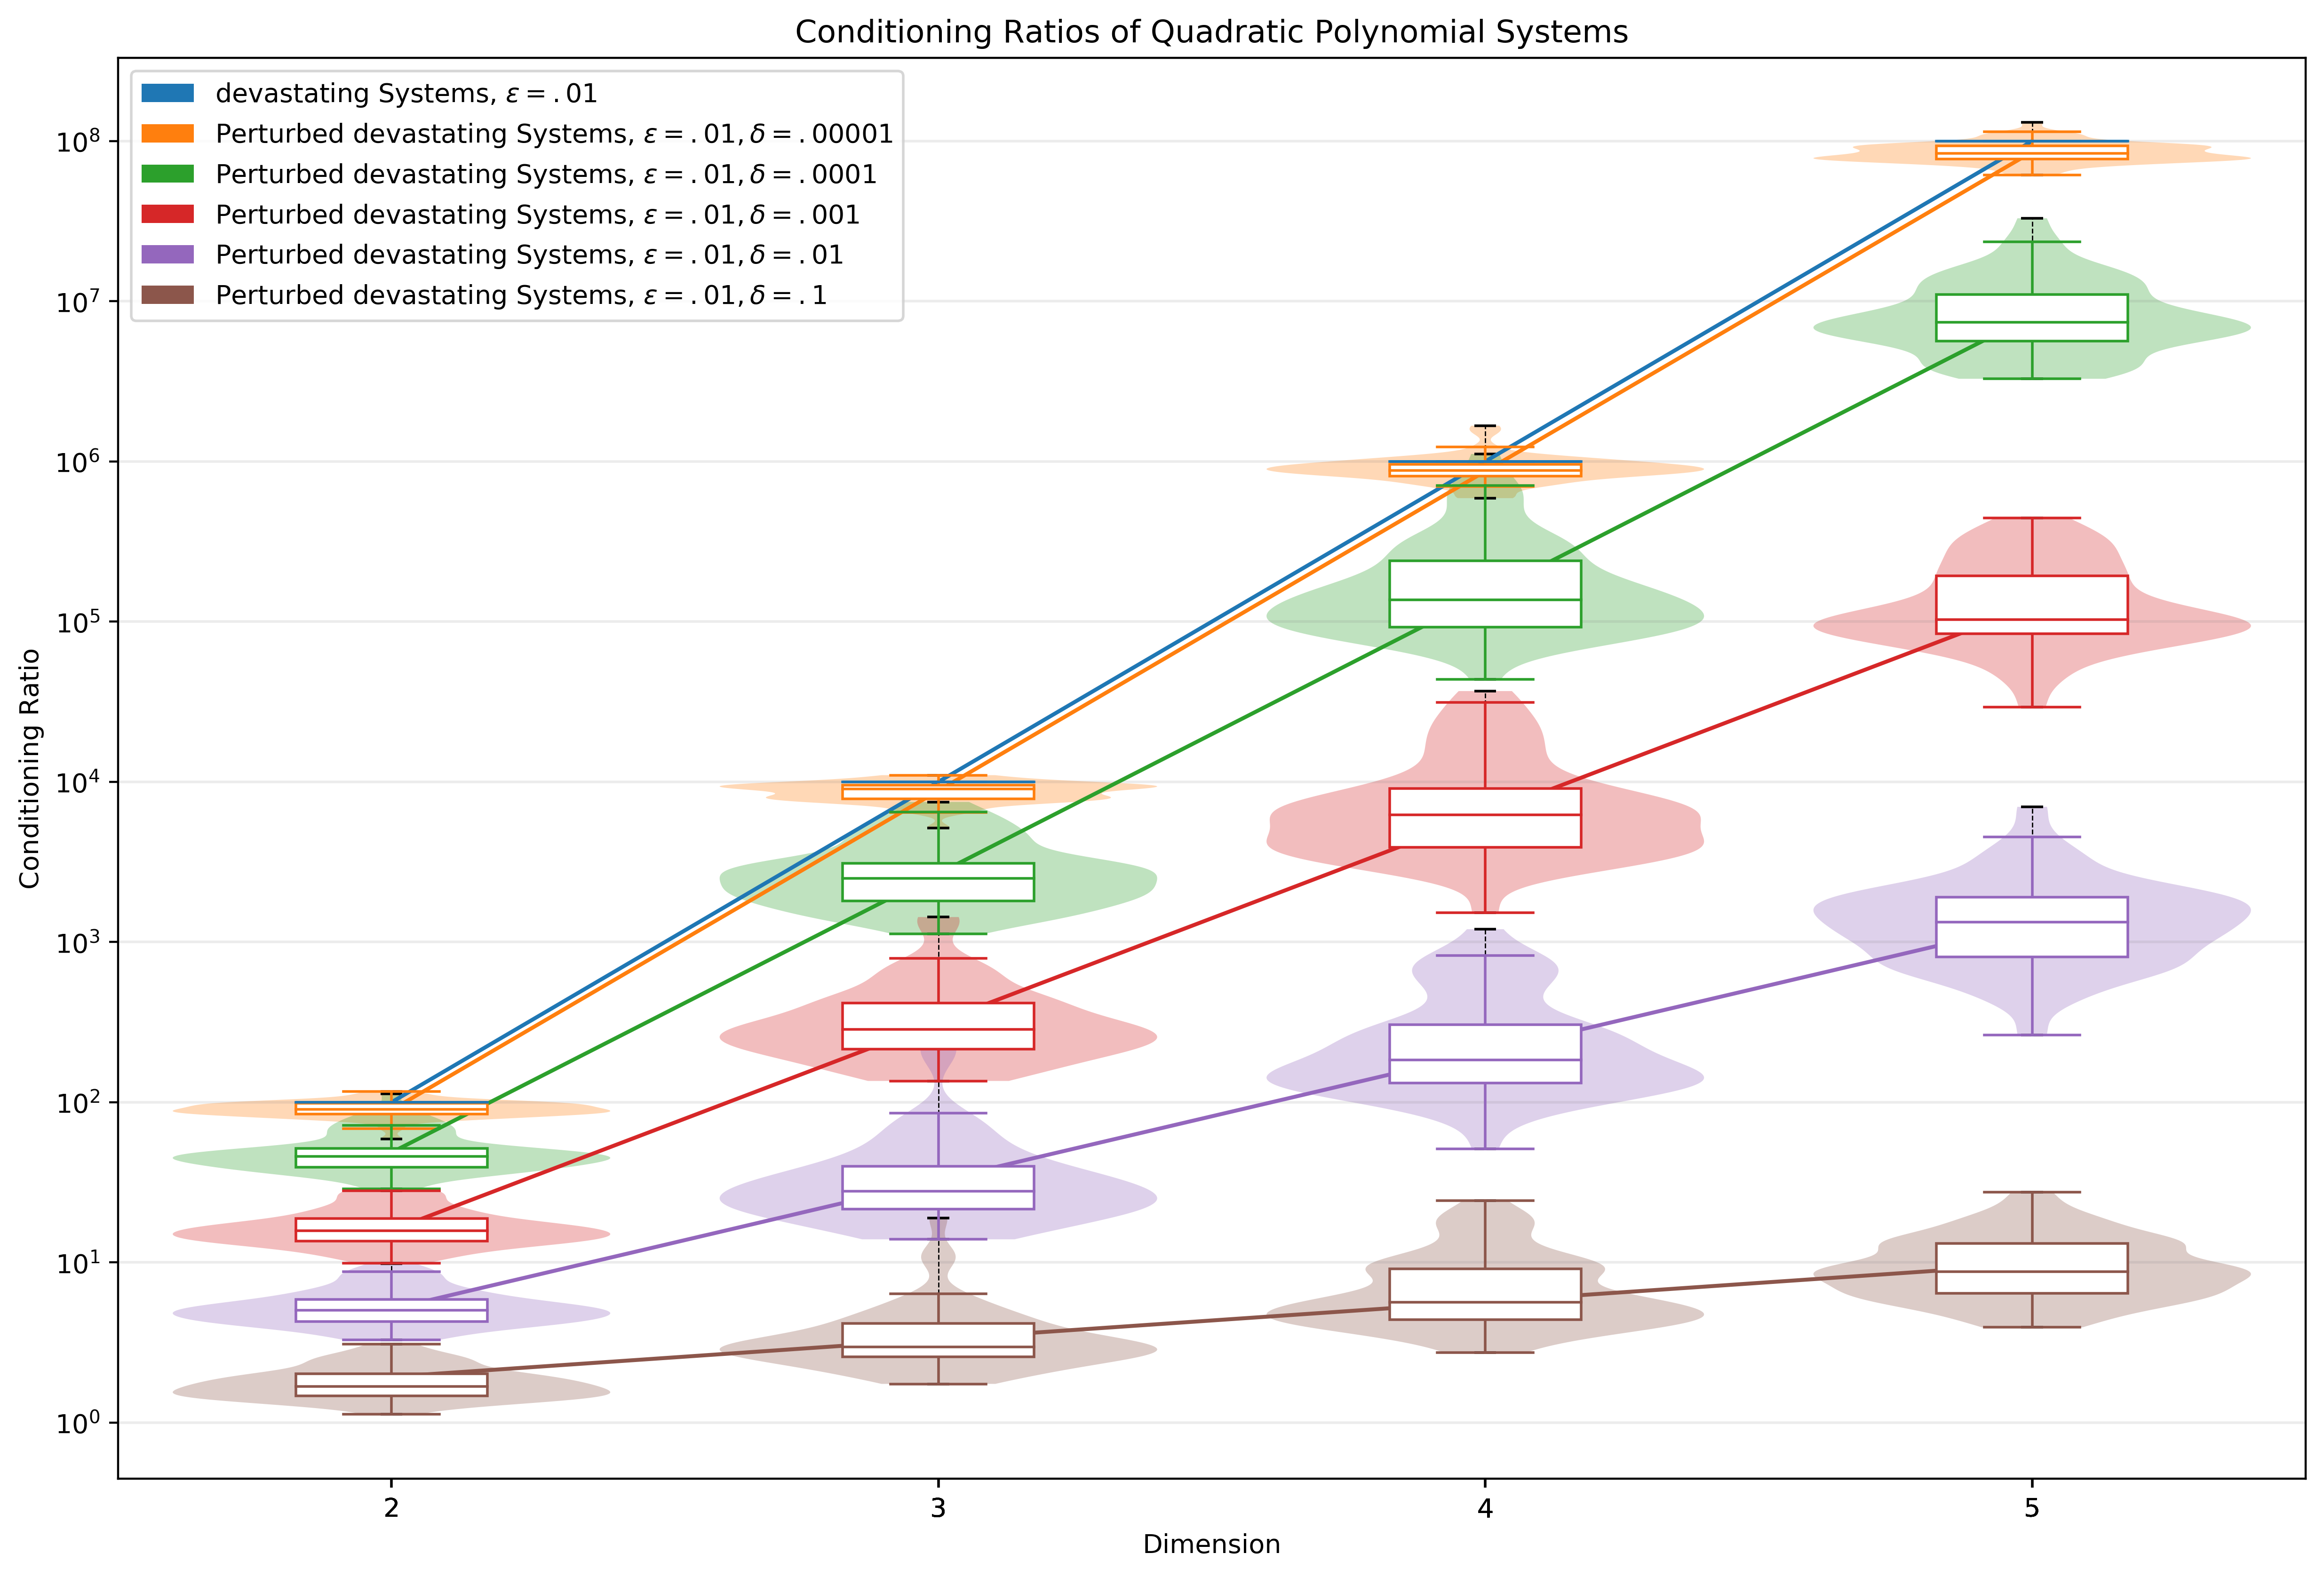

In [34]:
plot([dev_2,
      dev_2_delta_5,
      dev_2_delta_4,
      dev_2_delta_3,
      dev_2_delta_2,
      dev_2_delta_1],
     [r'devastating Systems, $\epsilon=.01$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.00001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.0001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.001$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.01$',
      r'Perturbed devastating Systems, $\epsilon=.01, \delta=.1$',
      r'Random Systems'],
     figsize=(15,10), filename='perturbed')

# How do the slopes of these lines decrease as you perturb more and more?

```
deltas,slopes = [],[]
for delta in np.logspace(-6,-1):
    print('delta =',delta,end='\r')
    data = devastating_conditioning_ratios([2,3,4,5],.01,
                                      'power',
                                      newton=False,
                                      save=False,
                                      delta=delta)
    data_log10 = [np.log10(data[d].flatten()) for d in data.keys()]
    points = np.array([[d,val] for i,d in enumerate(data.keys()) for val in data_log10[i]])
    slope = linregress(points)[0]
    deltas.append(delta)
    slopes.append(slope)
```

```
np.save('tests/conditioning_ratios/deltas.npy',deltas)
np.save('tests/conditioning_ratios/deltaslopes.npy',slopes)
```

In [40]:
deltas = np.load('tests/conditioning_ratios/deltas.npy')
slopes = np.load('tests/conditioning_ratios/deltaslopes.npy')
#from the manually computed data above, adding in a few data points
_slopes = [1.993731058425459, 1.741003395634404,1.29853652887252,0.8021768824007329,0.2343819610344608]
_deltas = [1e-5,1e-4,1e-3,1e-2,1e-1]
alldeltas = np.array(list(deltas) + _deltas)
allslopes = np.array(list(slopes) + _slopes)
srt = np.argsort(alldeltas)

$\delta=0$
Slope: 1.9999992674663203 
Intercept: -1.9999754282694306 
Exponential Growth Rate: 98.99983132802915

$\delta=10^{-4}$
Slope: 1.741003395634404 
Intercept: -1.7957199962783799 
Exponential Growth Rate: 54.081200304284344

$\delta=10^{-3}$
Slope: 1.29853652887252 
Intercept: -1.3961163092855222 
Exponential Growth Rate: 18.885500619735982

$\delta=10^{-2}$
Slope: 0.8021768824007329 
Intercept: -0.8951716367872398 
Exponential Growth Rate: 5.3412793059111054

Unperturbed
Slope: 1.9999992674663203 
Intercept: -1.9999754282694306 
Exponential Growth Rate: 98.99983132802915

$\delta=10^{-4}$
Slope: 1.741003395634404 
Intercept: -1.7957199962783799 
Exponential Growth Rate: 54.081200304284344

$\delta=10^{-3}$
Slope: 1.29853652887252 
Intercept: -1.3961163092855222 
Exponential Growth Rate: 18.885500619735982

$\delta=10^{-2}$
Slope: 0.8021768824007329 
Intercept: -0.8951716367872398 
Exponential Growth Rate: 5.3412793059111054



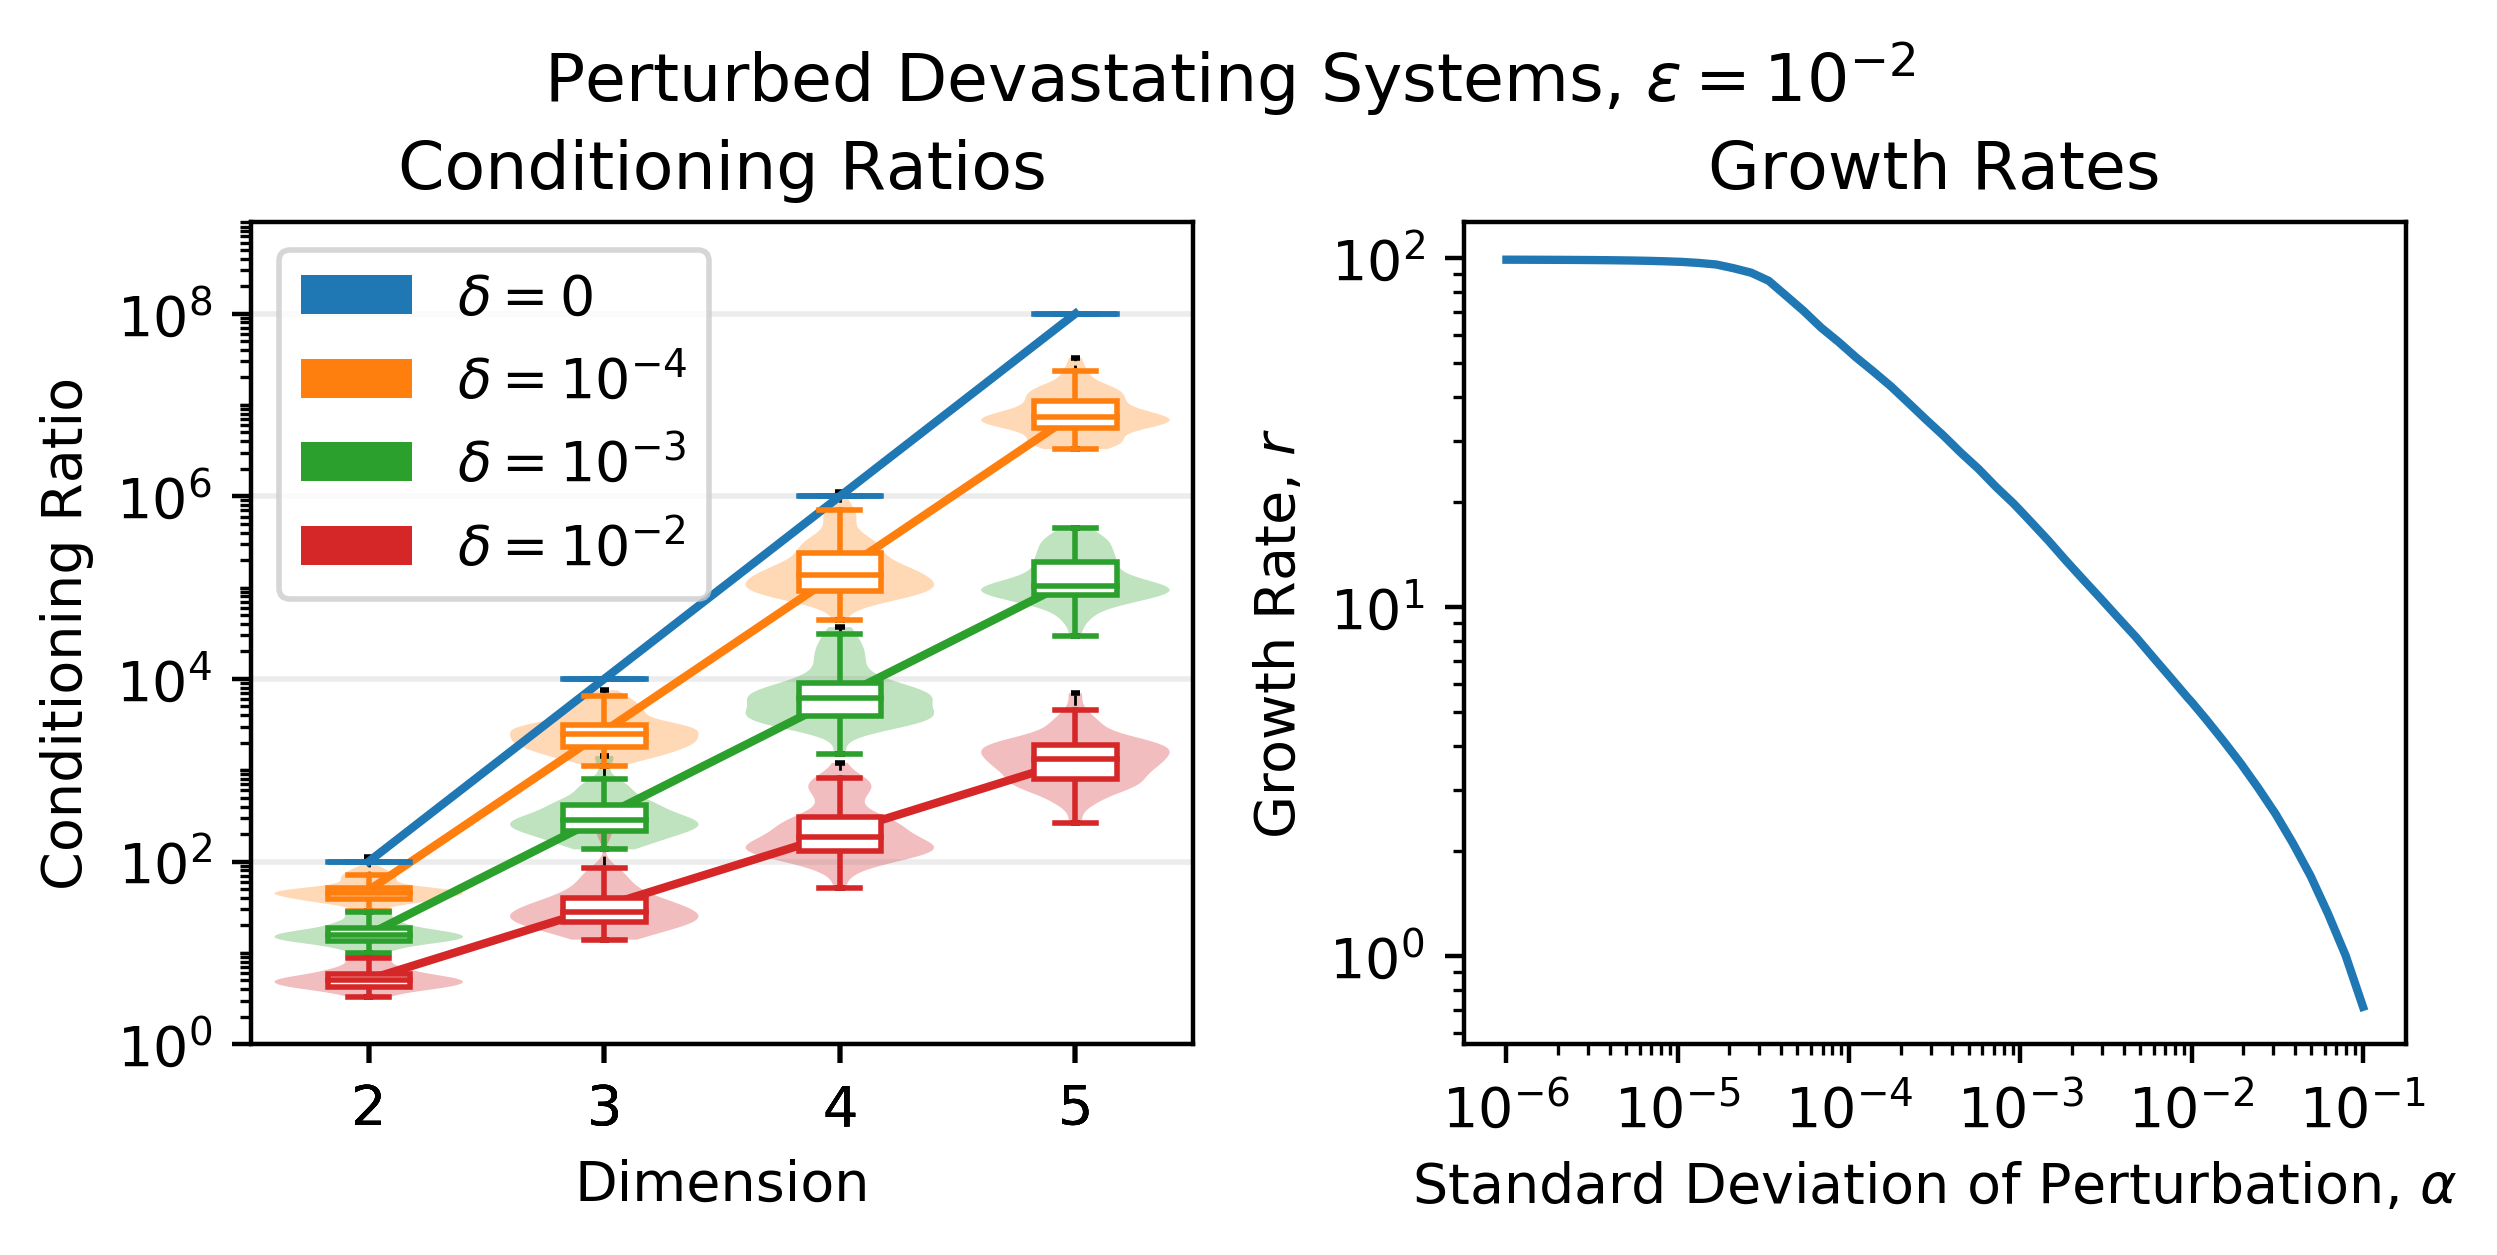

In [42]:
plot([[dev_2,
      dev_2_delta_4,
      dev_2_delta_3,
      dev_2_delta_2],
      [dev_2,
      dev_2_delta_4,
      dev_2_delta_3,
      dev_2_delta_2]],
     [[r'$\delta=0$',
      r'$\delta=10^{-4}$',
      r'$\delta=10^{-3}$',
      r'$\delta=10^{-2}$',],
      [r'Unperturbed',
      r'$\delta=10^{-4}$',
      r'$\delta=10^{-3}$',
      r'$\delta=10^{-2}$',]
      ],
     figsize=(6.25,3.25), filename='perturbed_small_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Perturbed Devastating Systems, $\varepsilon=10^{-2}$'],
     subplots=[1,2], _2nd_plot=[alldeltas[srt],10**np.array(allslopes[srt])-1],
     min_ylim=0,max_ylim=9)

summary: 

perturbing opens up new choices of basis

cond num probably isn't cont at zero

#### FIGURES IN THE PAPER:
* figsize is the desired actual size in the final printed article, measured in inches -- controlable
* dpi at least 300 -- defaults to 400
* file type  pdf -- does that in saving
* bbox_inches = ‘tight’ -- does that in saving

In [17]:
def get_log_medians(data):
    return [np.median(np.log10(data[d])) for d in data.keys()]
def get_perc_neg(data):
    return [np.mean(np.log10(data[d])<0)*100 for d in data.keys()]

In [18]:
print('log medians')
print('Rand:',np.round(get_log_medians(rand_polished),4))
print('Dev :',np.round(get_log_medians(dev_polished),4))
print('Rand % Negative:',np.round(get_perc_neg(rand_polished),4))

log medians
Rand: [0.2801 0.2958 0.3331 0.3817 0.4027 0.4176 0.452 ]
Dev : [1.0028 2.0018 3.0015 4.0021 5.0019 6.0012 7.0034]
Rand % Negative: [9.5833 9.096  6.9107 5.0902 4.2508 3.7985 3.8086]


# Generate Random Systems with known roots

Goal: Find $n$ hyperellipses that have common roots at  chosen points $\mathbf {r_1,\ldots,r_n}$. 

Let's just take this one hyperellipse at a time.

Pick a chosen center $\mathbf c$ of the hyperellipse.

Then the equation for the hyperellipse is

$$f(\mathbf x) = \sum_{j=1}^n \frac{(x_j - c_j)^2}{a_{j}^2} - 1$$

and it has a root at $\mathbf r_i$ iff

$$\sum_{j=1}^n \frac{(r_{ij} - c_j)^2}{a_{j}^2} = 1$$

Good news! This is just a linear system in $1/a_i^2$!

$$\begin{bmatrix}
(r_{11} - c_1)^2       &   (r_{11} - c_2)^2       & \dots     &   (r_{1n} - c_n)^2       \\
(r_{21} - c_1)^2       &   (r_{21} - c_2)^2       & \dots     &   (r_{2n} - c_n)^2       \\
\vdots  &  \vdots   &   \vdots  &   \vdots  \\   
(r_{n1} - c_1)^2       &   (r_{n1} - c_2)^2       & \dots     &   (r_{nn} - c_n)^2       \\
\end{bmatrix}
\begin{bmatrix}
1/a_1^2    \\
1/a_2^2     \\
\vdots  \\
1/a_n^2     \\
\end{bmatrix}=
\mathbb 1$$

If you get a solution that has some negative outputs for $1/a_i^2$, then you've got some sort of cross between a hyperellipse and a hyperhyperbola.

For convenience, we're just going to use $1/a_i^2$ for our coefficients and not actually convert to $a_i$. In the code, I've denoted the $\mathbf a$ vector as `scalar`.

If we repeat this process $n$ times, we end up with $n$ hyper-conics that have common roots at $\mathbf {r_1,\ldots,r_n}$.

In [19]:
np.random.seed(0)
dim = 2
roots = np.random.randn(dim,dim)
centers = np.random.randn(dim,dim)
print('Chosen Roots:',*roots)
print('Chosen Centers:',*centers)

Chosen Roots: [1.76405235 0.40015721] [0.97873798 2.2408932 ]
Chosen Centers: [ 1.86755799 -0.97727788] [ 0.95008842 -0.15135721]


In [20]:
scalars = [get_scalar(c,roots) for c in centers]
print('Scalars:',*scalars)

Scalars: [-6.09487717  0.56147239] [1.42922176 0.17453276]


In [21]:
polys = [get_MultiPower(c,roots) for c in centers]
print('Coefficients of Polynomials:',*[p.coeff for p in polys],sep='\n')

Coefficients of Polynomials:
[[-21.72130051   1.0974291    0.56147239]
 [ 22.76507313   0.           0.        ]
 [ -6.09487717   0.           0.        ]]
[[ 0.29411112  0.05283358  0.17453276]
 [-2.71577408  0.          0.        ]
 [ 1.42922176  0.          0.        ]]


In [24]:
er.solve(polys)

array([[ 0.97873798+0.j        ,  2.2408932 +0.j        ],
       [ 1.57470473-0.40344222j, -2.33352442-0.94564756j],
       [ 1.57470473+0.40344222j, -2.33352442+0.94564756j],
       [ 1.76405235+0.j        ,  0.40015721+0.j        ]])

# Generate Random Systems that Almost have Multiple Roots

### roots of multiplicity dim

In [28]:
mult1,eigconds1,rootconds1 = get_data(alpha=.1,gen_func=gen_almost_multiple_roots, detailed=True)

2
3
4


In [29]:
mult2,eigconds2,rootconds2 = get_data(alpha=.01,gen_func=gen_almost_multiple_roots, detailed=True)

2
3
4


In [30]:
mult3,eigconds3,rootconds3 = get_data(alpha=.001,gen_func=gen_almost_multiple_roots, detailed=True)

2
3
4


In [32]:
mult4,eigconds4,rootconds4 = get_data(alpha=.0001,gen_func=gen_almost_multiple_roots, detailed=True)

2
3
4


In [33]:
mult5,eigconds5,rootconds5 = get_data(alpha=.00001,gen_func=gen_almost_multiple_roots, detailed=True)

2
3
4


In [34]:
mult6,eigconds6,rootconds6 = get_data(alpha=.000001,gen_func=gen_almost_multiple_roots, detailed=True)

2
3
4


$\alpha=10^{-6}$
Slope: 0.4479311264310323 
Intercept: 5.57890653673452 
Exponential Growth Rate: 1.8049887672133647

$\alpha=10^{-5}$
Slope: 0.4467208781188835 
Intercept: 4.5845748726134765 
Exponential Growth Rate: 1.7971829870286848

$\alpha=10^{-4}$
Slope: 0.4483146169329381 
Intercept: 3.5806829095559047 
Exponential Growth Rate: 1.807466720908263

$\alpha=10^{-3}$
Slope: 0.4436661314805303 
Intercept: 2.5908737706378338 
Exponential Growth Rate: 1.777577154693681

$\alpha=10^{-2}$
Slope: 0.4459462368300157 
Intercept: 1.5858215909516378 
Exponential Growth Rate: 1.7921981616975904

$\alpha=10^{-1}$
Slope: 0.43264279672049993 
Intercept: 0.6151669469582972 
Exponential Growth Rate: 1.7079634402695398



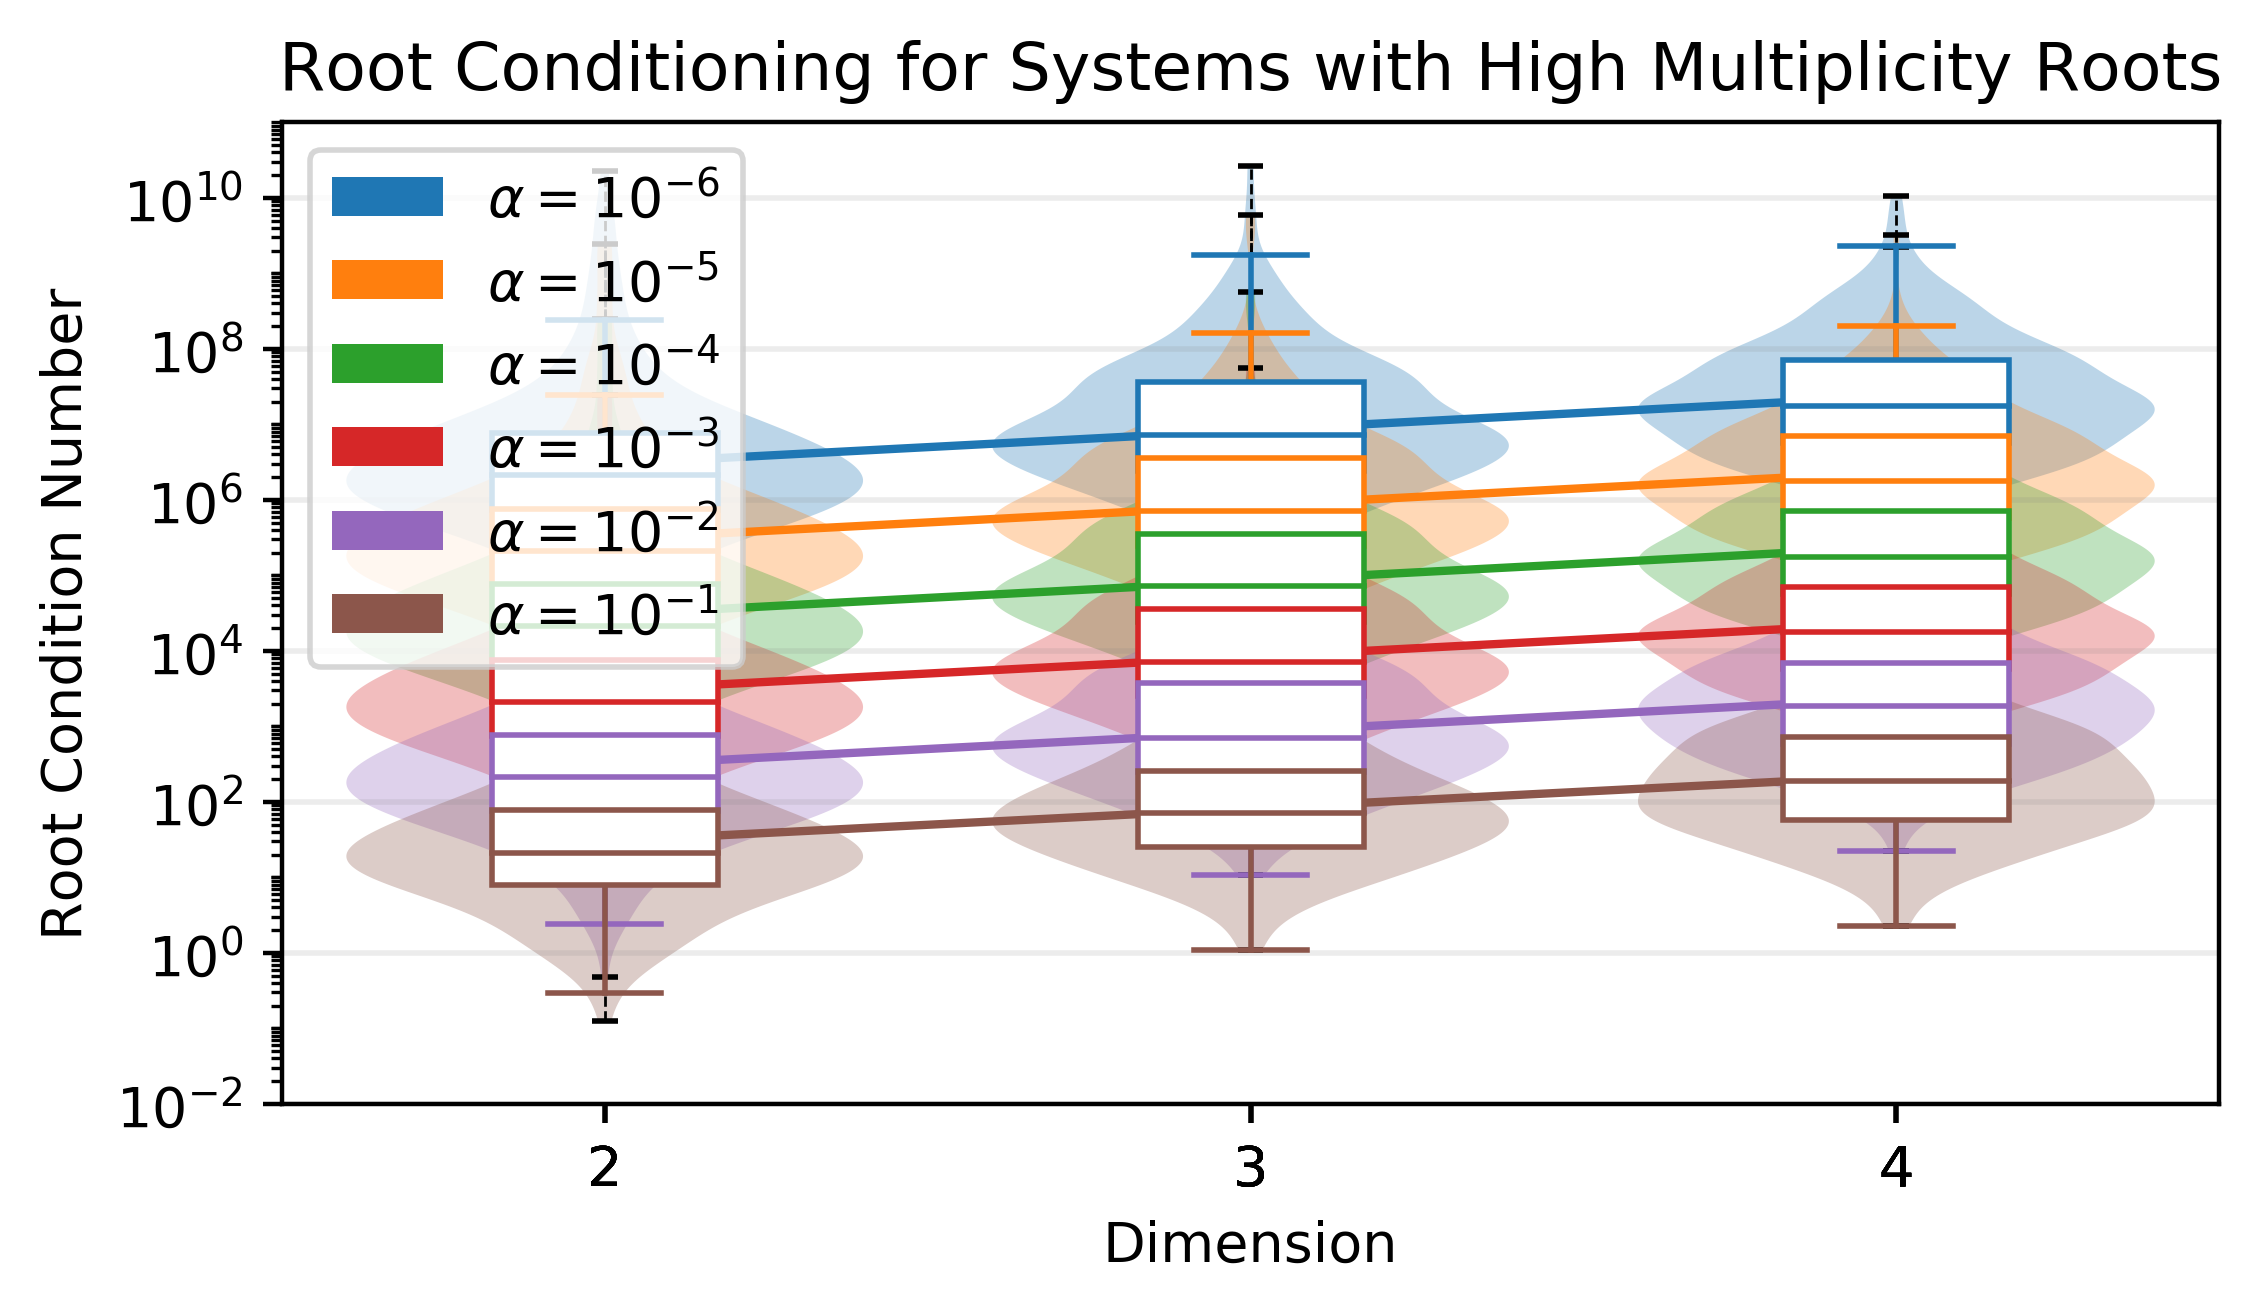

In [38]:
plot([rootconds6,
      rootconds5,
      rootconds4,
      rootconds3,
      rootconds2,
      rootconds1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_root_conds', 
     title='Root Conditioning for Systems with High Multiplicity Roots',
     yaxislabel='Root Condition Number',
     min_ylim=-2,
     max_ylim=11)

$\alpha=10^{-6}$
Slope: 1.4225044006077738 
Intercept: 3.5284836306371403 
Exponential Growth Rate: 25.45479500633772

$\alpha=10^{-5}$
Slope: 1.525979096564605 
Intercept: 3.299887278638807 
Exponential Growth Rate: 32.57214549295682

$\alpha=10^{-4}$
Slope: 2.1673524598350524 
Intercept: 0.9630887175989749 
Exponential Growth Rate: 146.0118896205113

$\alpha=10^{-3}$
Slope: 2.910797553707557 
Intercept: -2.2336069332787725 
Exponential Growth Rate: 813.3245982715696

$\alpha=10^{-2}$
Slope: 2.075314253488284 
Intercept: -1.6260394145091448 
Exponential Growth Rate: 117.93625333979418

$\alpha=10^{-1}$
Slope: 1.1226803817384683 
Intercept: -0.7422009331042938 
Exponential Growth Rate: 12.264179234922832



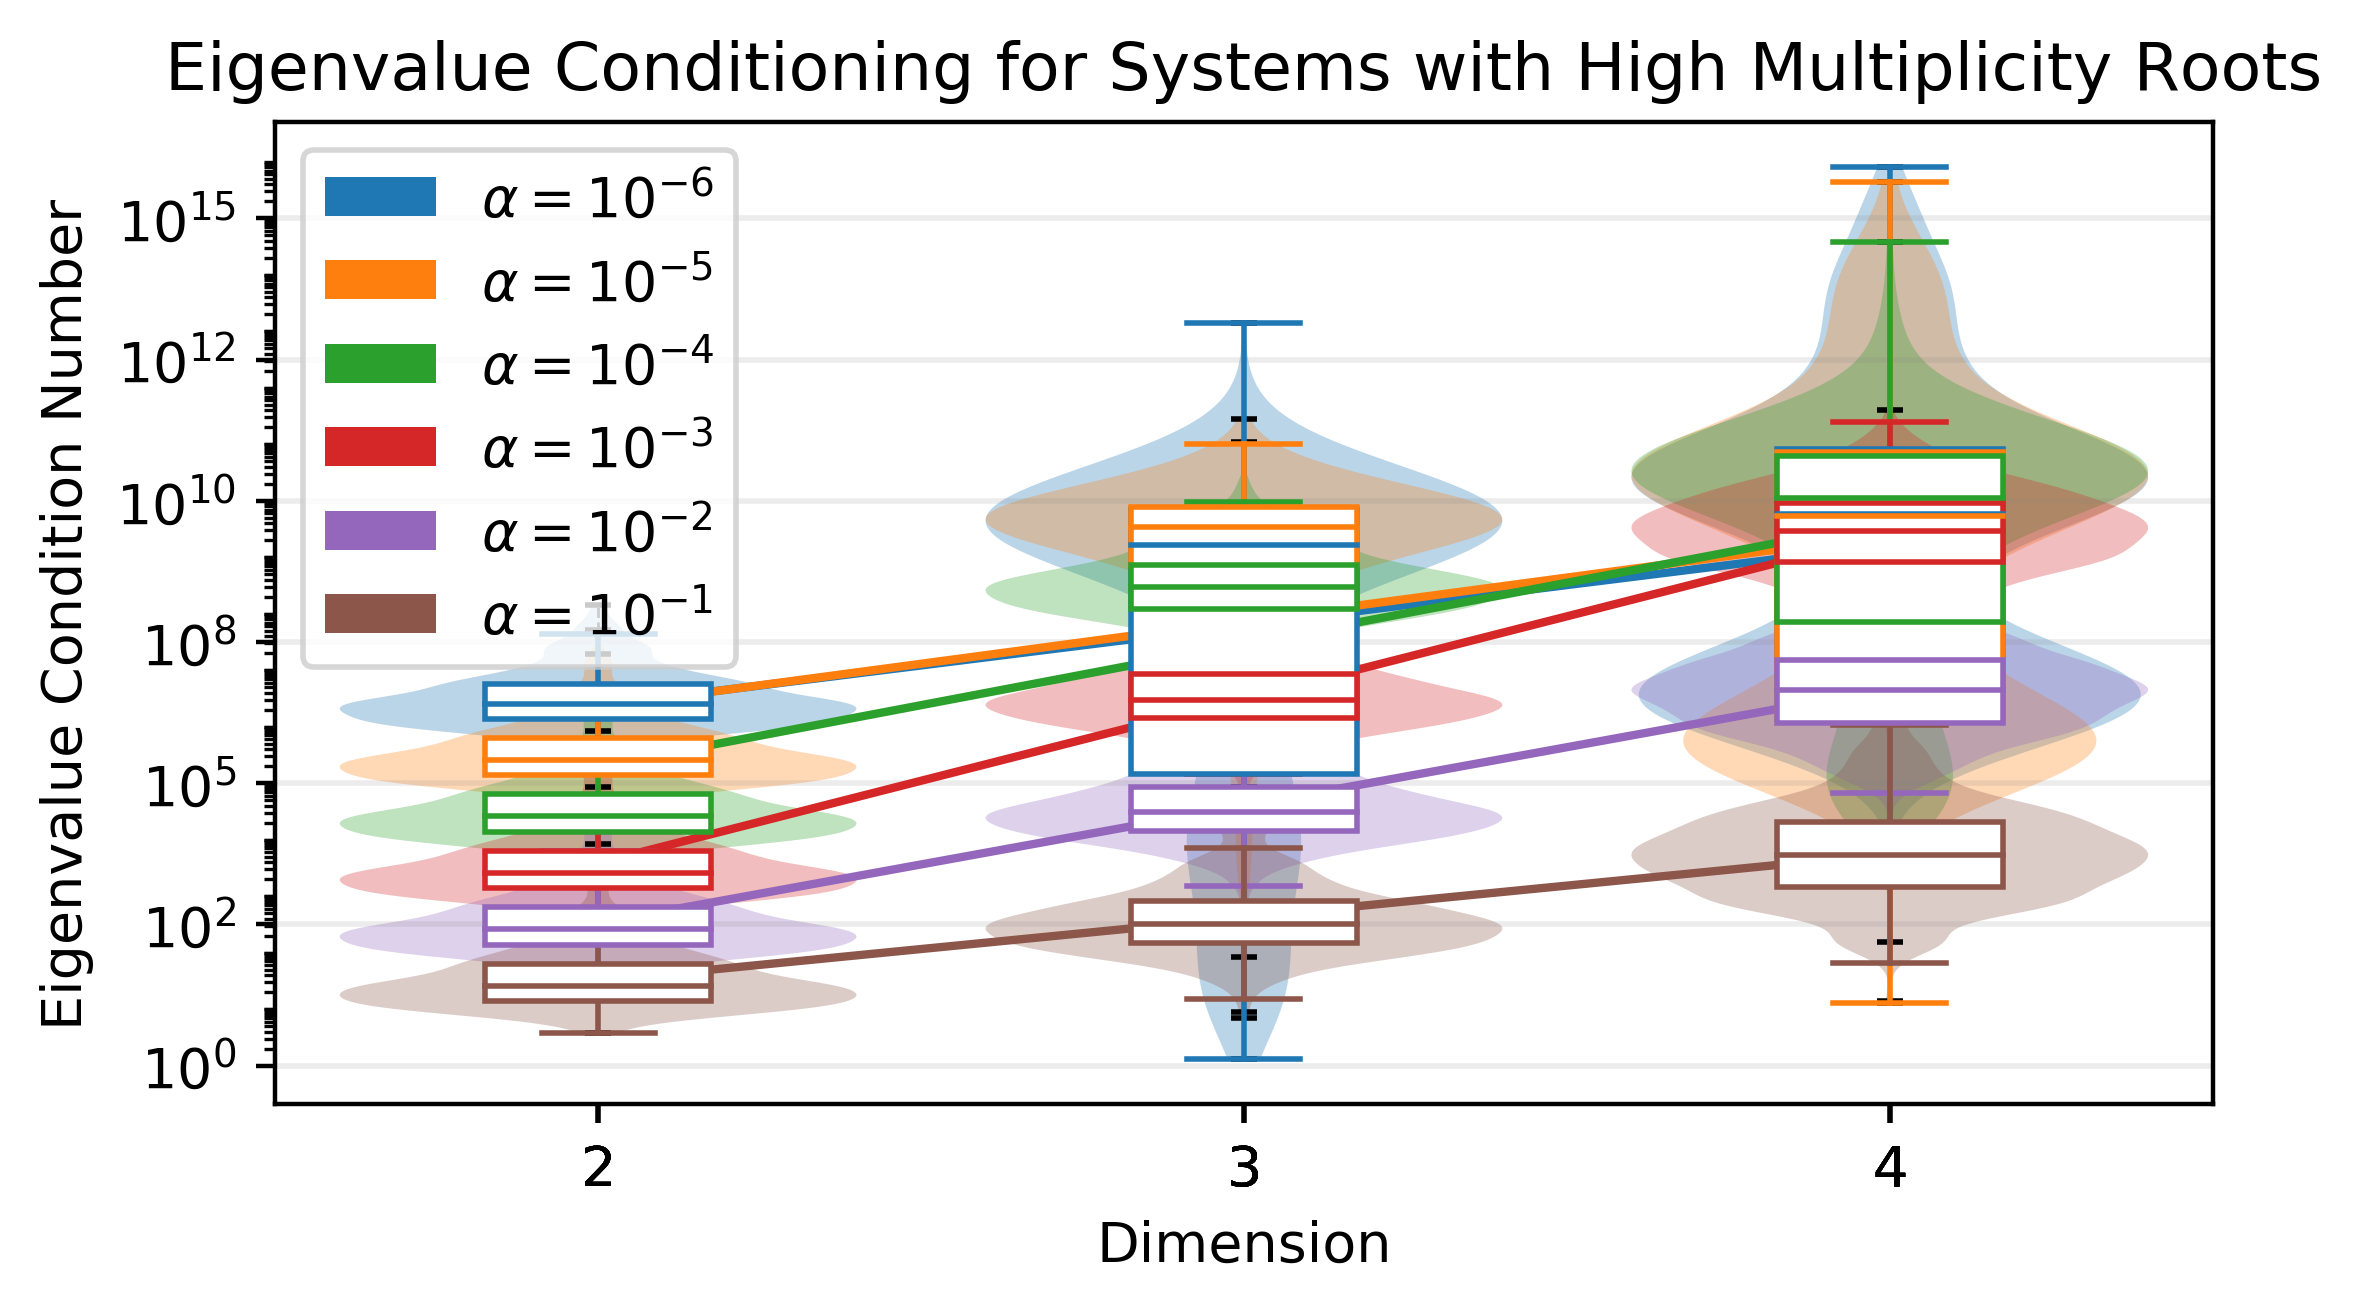

In [40]:
plot([eigconds6,
      eigconds5,
      eigconds4,
      eigconds3,
      eigconds2,
      eigconds1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_eig_conds', 
     title='Eigenvalue Conditioning for Systems with High Multiplicity Roots',
     yaxislabel='Eigenvalue Condition Number',
     min_ylim=0,
     max_ylim=16)

$\alpha=10^{-6}$
Slope: 0.9857371169531469 
Intercept: -2.0863952883769077 
Exponential Growth Rate: 8.676919247788993

$\alpha=10^{-5}$
Slope: 1.0906662394629774 
Intercept: -1.3214467728080503 
Exponential Growth Rate: 11.321575413706915

$\alpha=10^{-4}$
Slope: 1.730204741283626 
Intercept: -2.653576420075135 
Exponential Growth Rate: 52.728503122746936

$\alpha=10^{-3}$
Slope: 2.478646441932547 
Intercept: -4.86158465630106 
Exponential Growth Rate: 300.0554141578218

$\alpha=10^{-2}$
Slope: 1.6411530646972594 
Intercept: -3.249835049141977 
Exponential Growth Rate: 42.76763345906044

$\alpha=10^{-1}$
Slope: 0.6996369129914483 
Intercept: -1.3882990479771373 
Exponential Growth Rate: 4.0076839679360265



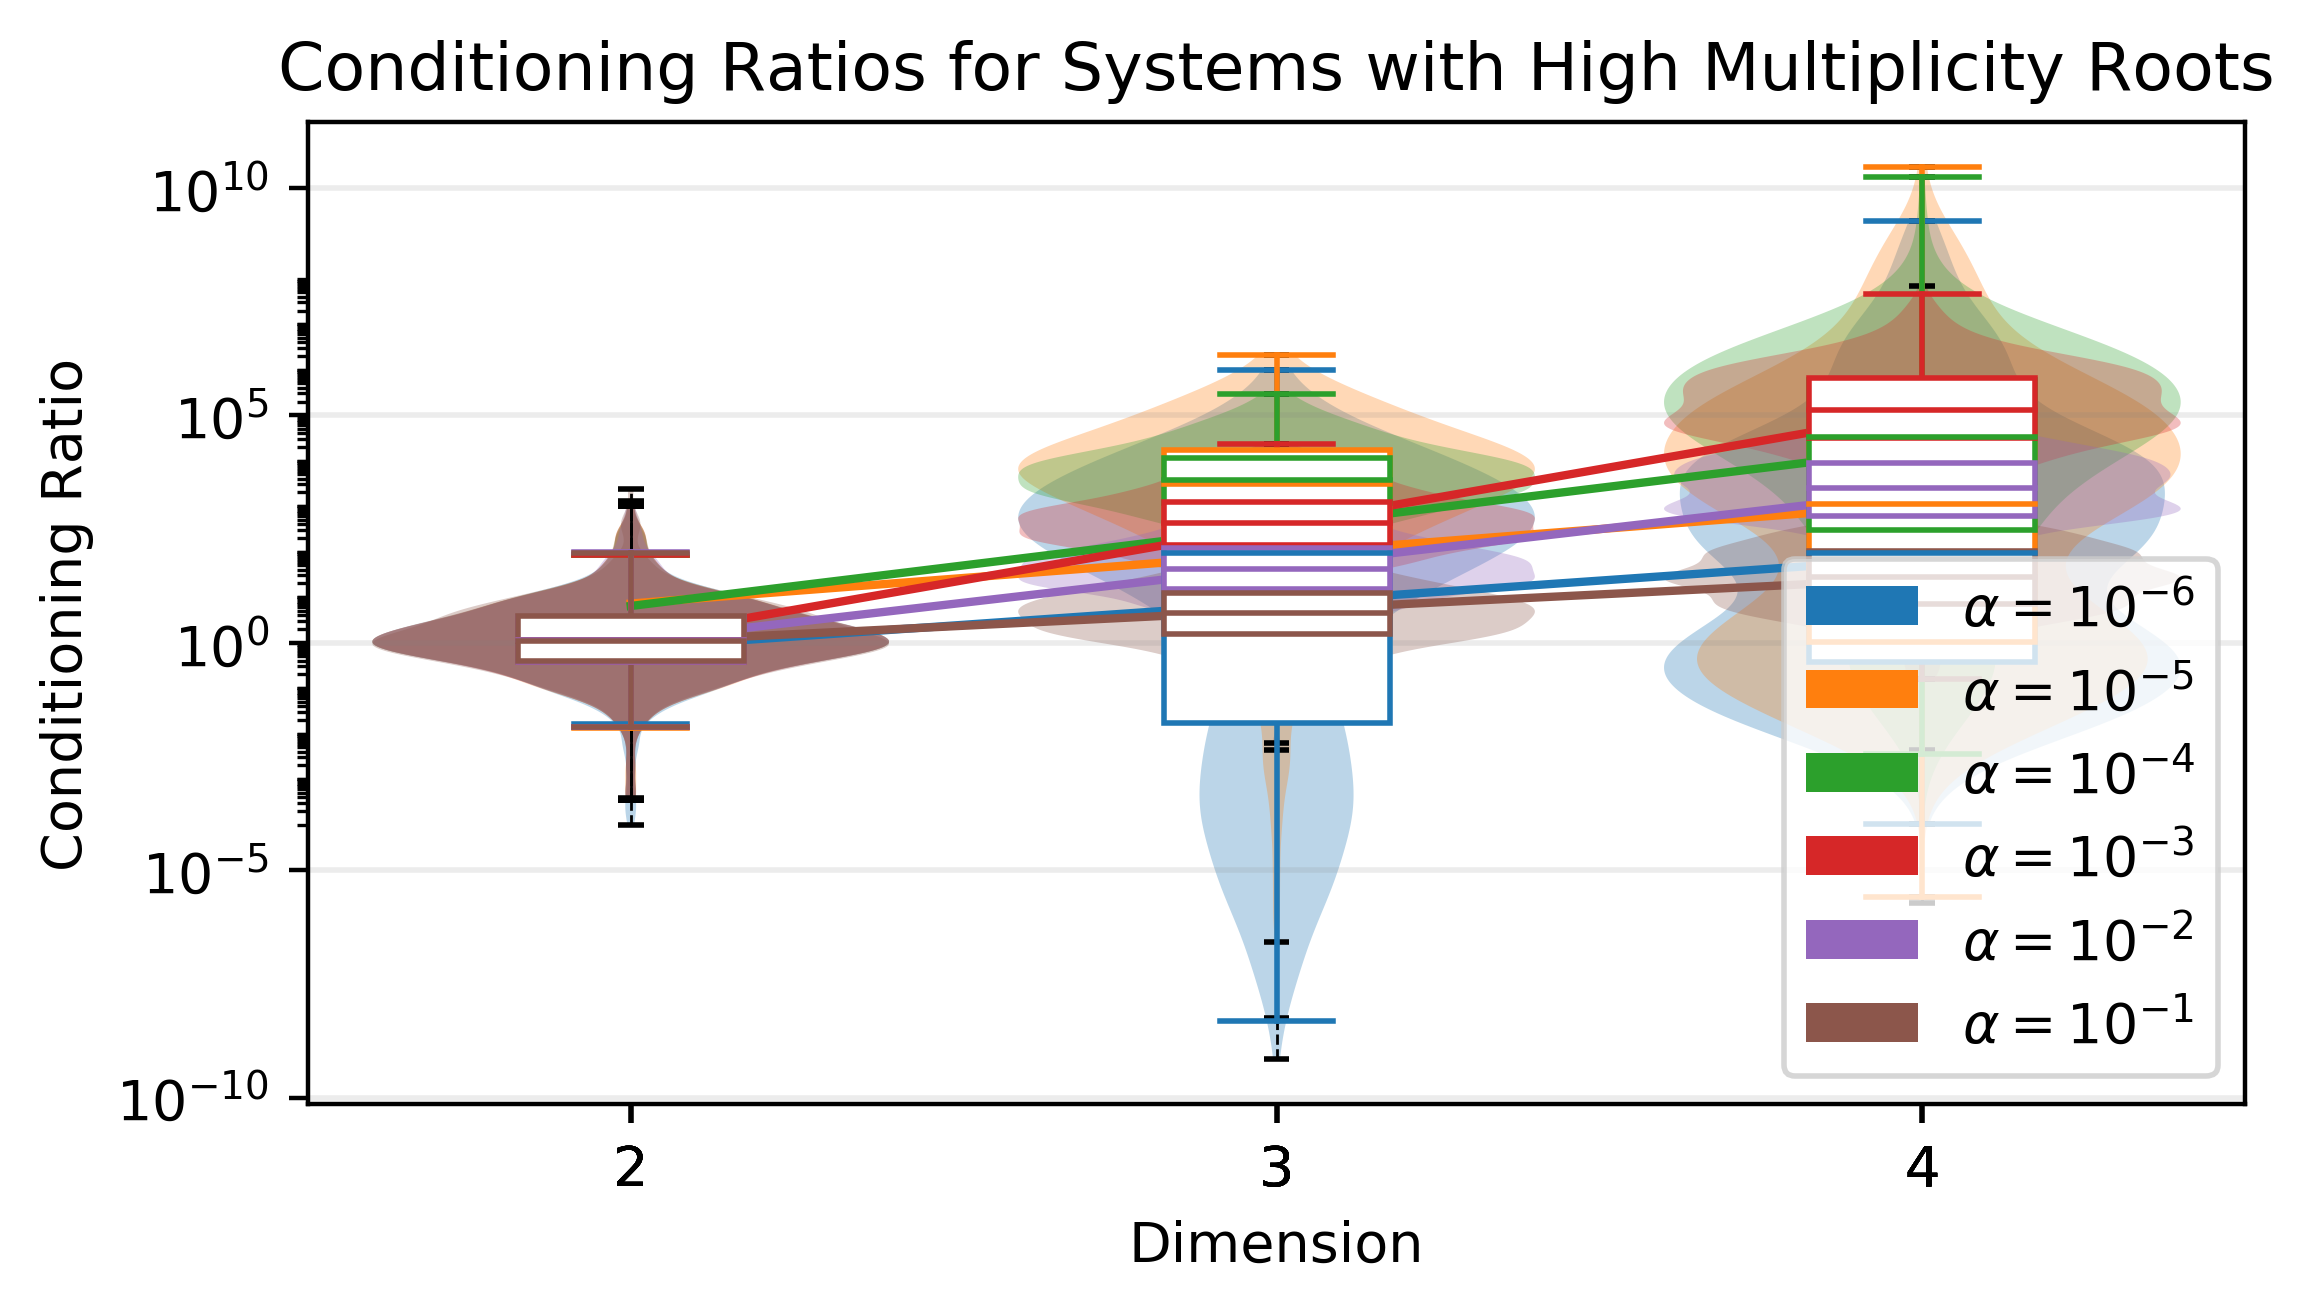

In [41]:
plot([mult6,
      mult5,
      mult4,
      mult3,
      mult2,
      mult1],
     [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-5}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
     figsize=(6.25,3.25), 
     filename='high_multiplicity_cr', 
     title='Conditioning Ratios for Systems with High Multiplicity Roots',
     min_ylim=-4,
     max_ylim=8)

In [42]:
alphas = np.logspace(-6,-1)
alphaslopes_multiples, alphaslopes_doubles= [],[]
for alpha in alphas:
    print('alpha =',alpha,end='\r')
    #multiple roots
    data_multiples = get_data(alpha,gen_func=gen_almost_multiple_roots)
    data_multiples_log10 = [np.log10(data_multiples[d].flatten()) for d in data_multiples.keys()]
    points_multiples = np.array([[d,val] for i,d in enumerate(data_multiples.keys()) for val in data_multiples_log10[i]])
    slope_multiples = linregress(points_multiples)[0]
    alphaslopes_multiples.append(slope_multiples)
    
    #double roots
    data_doubles = get_data(alpha,gen_func=gen_almost_double_roots)
    data_doubles_log10 = [np.log10(data_doubles[d].flatten()) for d in data_doubles.keys()]
    points_doubles = np.array([[d,val] for i,d in enumerate(data_doubles.keys()) for val in data_doubles_log10[i]])
    slope_doubles = linregress(points_doubles)[0]
    alphaslopes_doubles.append(slope_doubles)

2lpha = 1e-06
3
4
2
3
4
2lpha = 1.2648552168552959e-06
3
4
2
3
4
2lpha = 1.5998587196060574e-06
3
4
2
3
4
2lpha = 2.0235896477251557e-06
3
4
2
3
4
2lpha = 2.5595479226995334e-06
3
4
2
3
4
2lpha = 3.2374575428176467e-06
3
4
2
3
4
2lpha = 4.094915062380427e-06
3
4
2
3
4
2lpha = 5.179474679231212e-06
3
4
2
3
4
2lpha = 6.5512855685955095e-06
3
4
2
3
4
2lpha = 8.286427728546843e-06
3
4
2
3
4
2lpha = 1.0481131341546853e-05
3
4
2
3
4
2lpha = 1.3257113655901109e-05
3
4
2
3
4
2lpha = 1.67683293681101e-05
3
4
2
3
4
2lpha = 2.1209508879201926e-05
3
4
2
3
4
2lpha = 2.6826957952797274e-05
3
4
2
3
4
2lpha = 3.39322177189533e-05
3
4
2
3
4
2lpha = 4.291934260128778e-05
3
4
2
3
4
2lpha = 5.4286754393238594e-05
3
4
2
3
4
2lpha = 6.866488450042999e-05
3
4
2
3
4
2lpha = 8.68511373751352e-05
3
4
2
3
4
2lpha = 0.00010985411419875583
3
4
2
3
4
2lpha = 0.00013894954943731373
3
4
2
3
4
2lpha = 0.0001757510624854793
3
4
2
3
4
2lpha = 0.00022229964825261955
3
4
2
3
4
2lpha = 0.0002811768697974231
3
4
2
3
4
2lpha

In [43]:
np.save('tests/conditioning_ratios/alphas',alphas)
np.save('tests/conditioning_ratios/alphaslopes_multiples',alphaslopes_multiples)
np.save('tests/conditioning_ratios/alphaslopes_doubles',alphaslopes_doubles)

$\alpha=10^{-4}$
Slope: 1.730204741283626 
Intercept: -2.653576420075135 
Exponential Growth Rate: 52.728503122746936

$\alpha=10^{-3}$
Slope: 2.478646441932547 
Intercept: -4.86158465630106 
Exponential Growth Rate: 300.0554141578218

$\alpha=10^{-2}$
Slope: 1.6411530646972594 
Intercept: -3.249835049141977 
Exponential Growth Rate: 42.76763345906044

$\alpha=10^{-1}$
Slope: 0.6996369129914483 
Intercept: -1.3882990479771373 
Exponential Growth Rate: 4.0076839679360265

$\alpha=5*10^{-4}$
Slope: 1.730204741283626 
Intercept: -2.653576420075135 
Exponential Growth Rate: 52.728503122746936



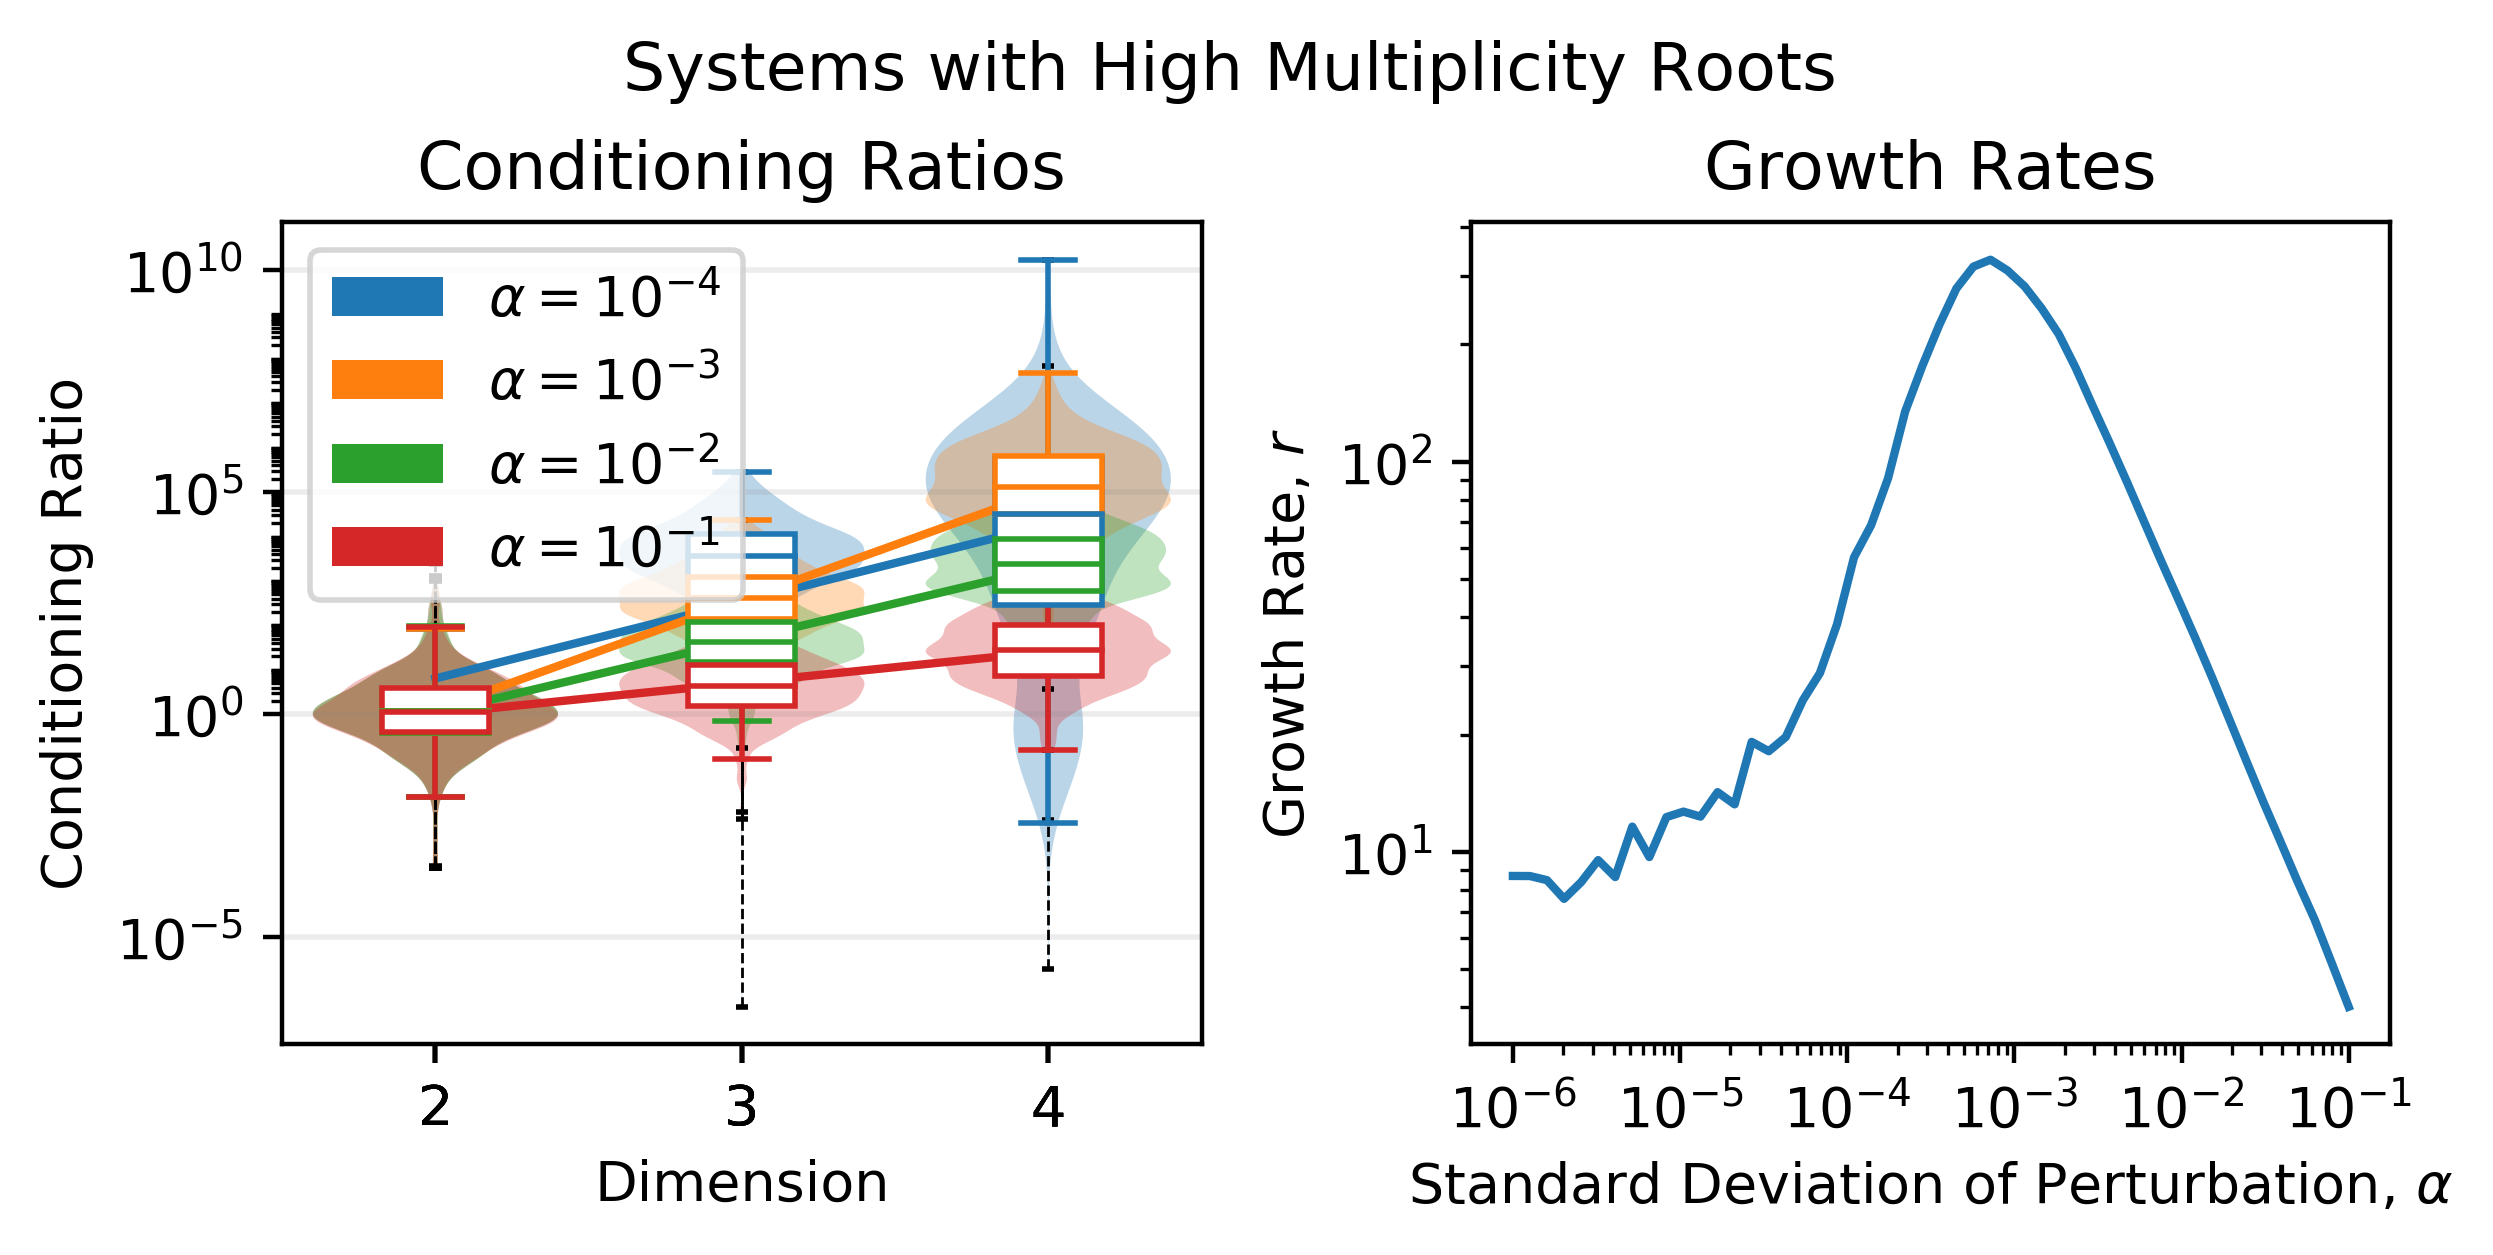

In [45]:
plot([[mult4,
      mult3,
      mult2,
      mult1],
     [mult4]],
     [[r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-3}$',
      r'$\alpha=10^{-2}$',
      r'$\alpha=10^{-1}$'],
      [r'$\alpha=5*10^{-4}$']],
     figsize=(6.25,3.25), filename='high_multiplicities_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Systems with High Multiplicity Roots'],
     subplots=[1,2], _2nd_plot=[alphas,10**np.array(alphaslopes_multiples)-1],
     min_ylim=0,max_ylim=9)

### double, not multiple roots

In [47]:
doub1 = get_data(alpha=.1,gen_func=gen_almost_double_roots)

2
3
4


In [52]:
doub2 = get_data(alpha=.01,gen_func=gen_almost_double_roots)

2
3
4


In [49]:
doub3 = get_data(alpha=.001,gen_func=gen_almost_double_roots)

2
3
4


$\delta=10^{-3}$
Slope: -0.07392482273080075 
Intercept: 0.23354112520716486 
Exponential Growth Rate: -0.1565192466166937

$\delta=10^{-2}$
Slope: -0.07509277038116655 
Intercept: 0.23595269292247686 
Exponential Growth Rate: -0.15878457100359988

$\delta=10^{-1}$
Slope: -0.07814334290258908 
Intercept: 0.21943550847037846 
Exponential Growth Rate: -0.16467273474819855



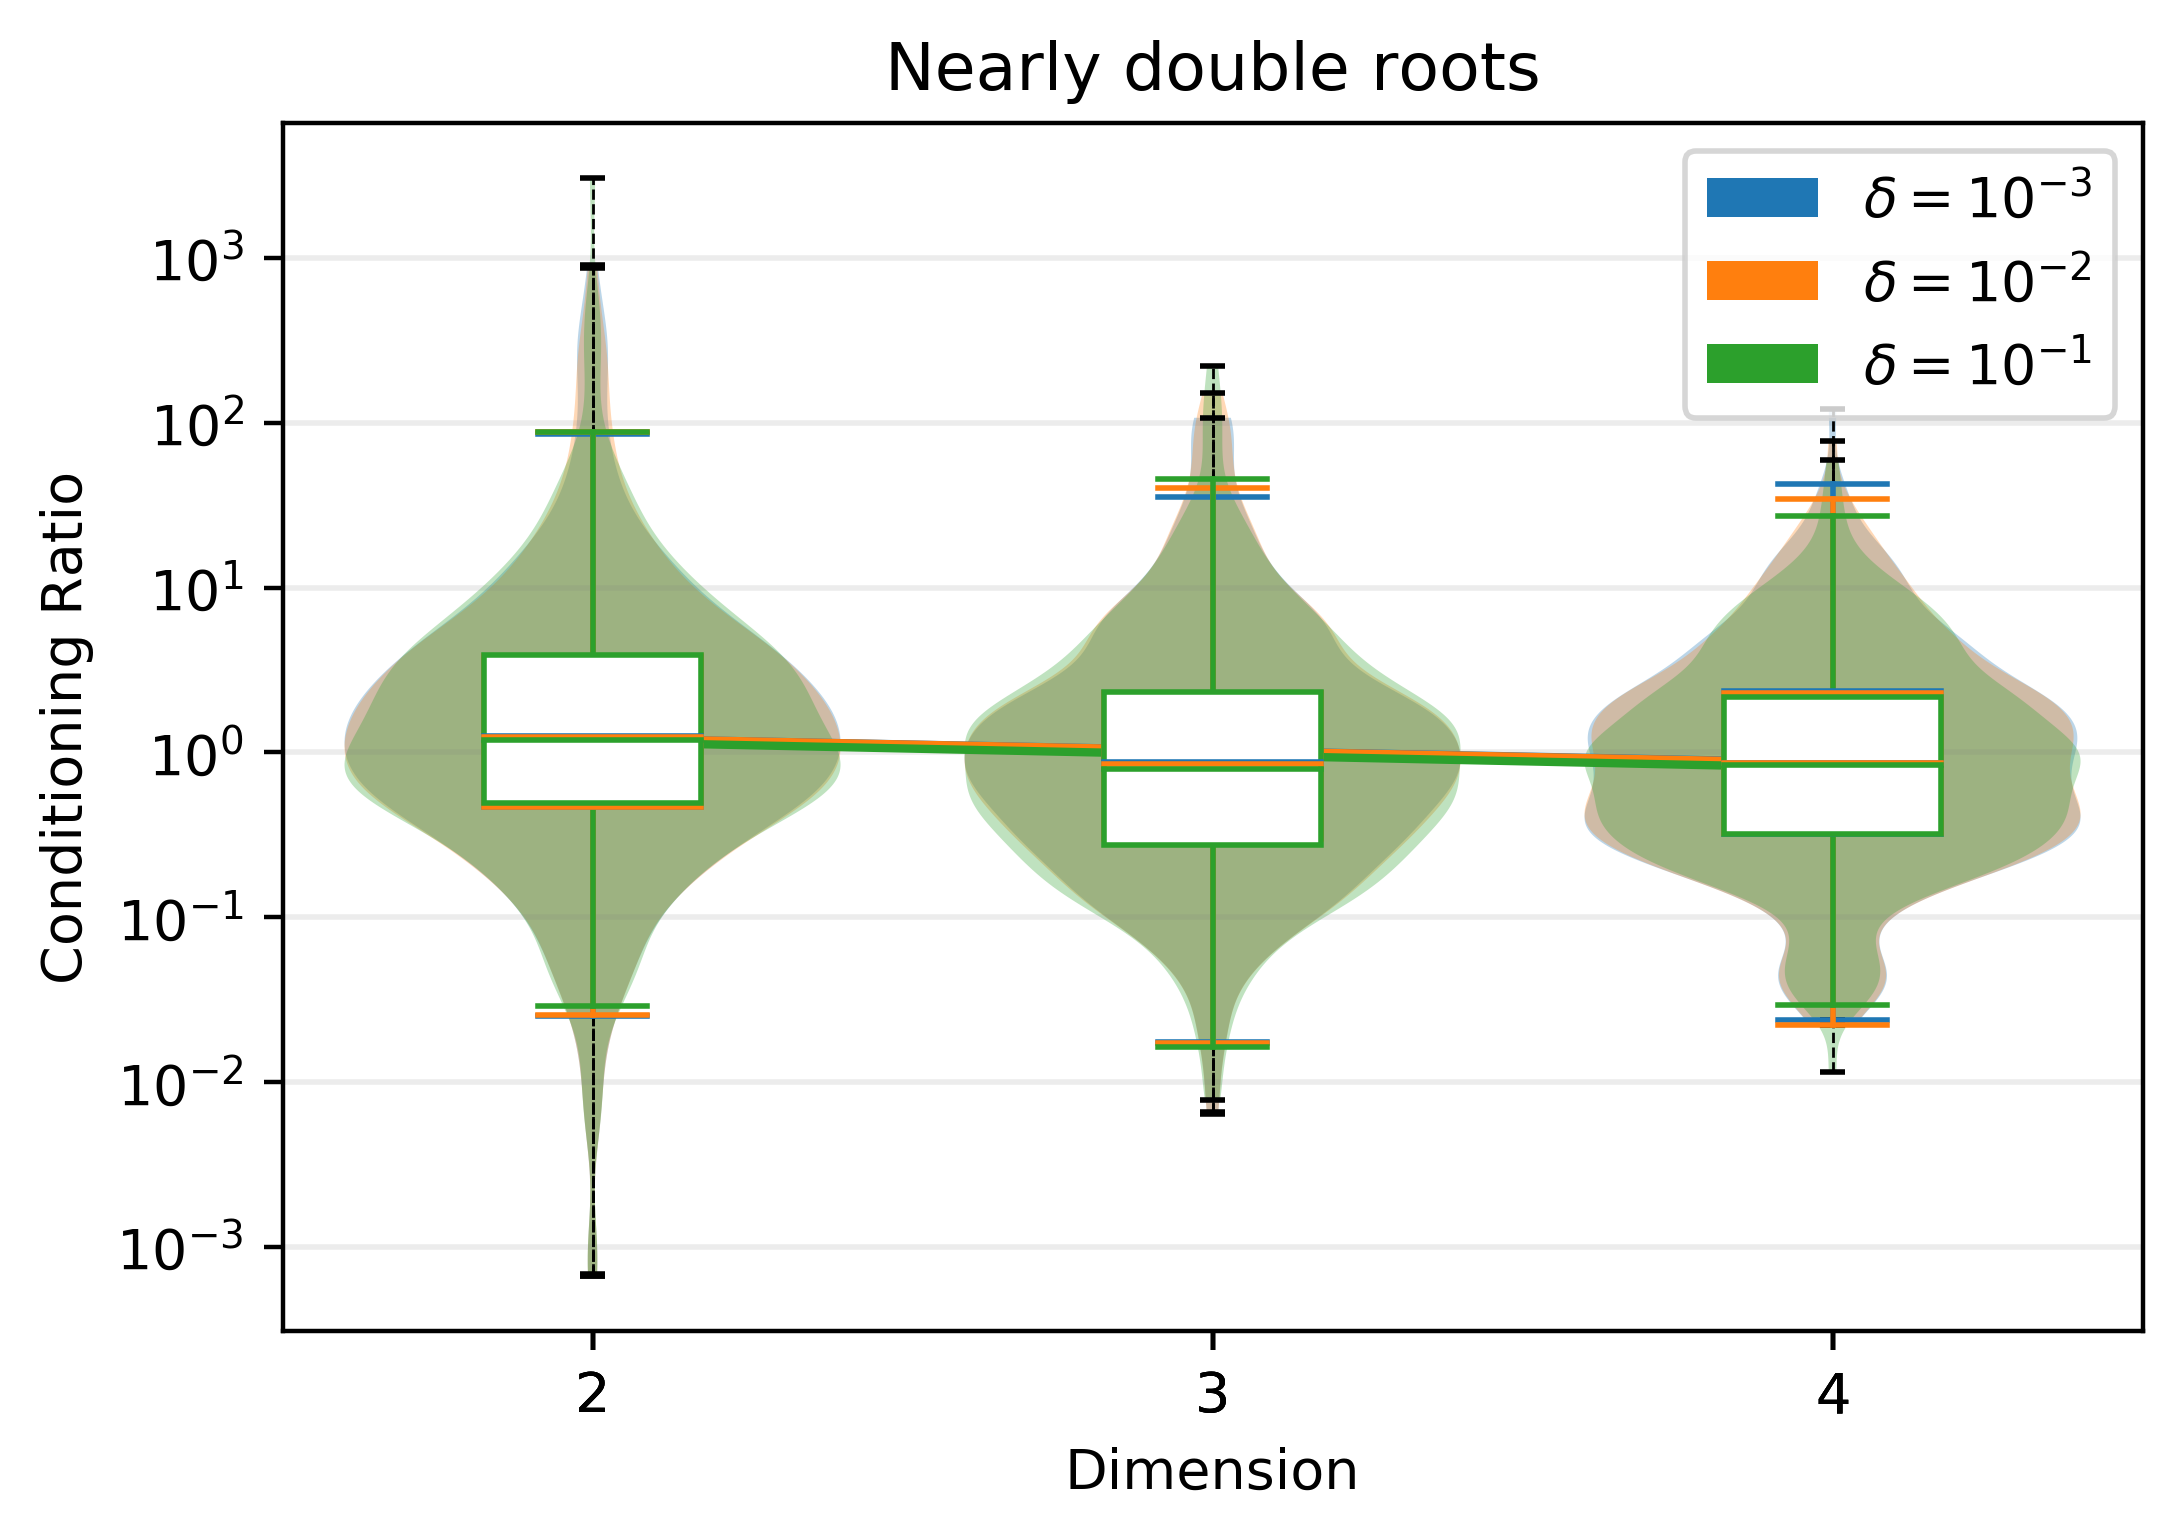

In [53]:
plot([doub3,doub2,doub1],
      [r'$\delta=10^{-3}$',
       r'$\delta=10^{-2}$',
       r'$\delta=10^{-1}$'],
     title = 'Nearly double roots', filename='nearly_double')

In [54]:
alphaslopes_doubles

[-0.07424644247157317,
 -0.07226681627569283,
 -0.07294929330397275,
 -0.07076609061231912,
 -0.0722018827533944,
 -0.07424013396170878,
 -0.07192307918897589,
 -0.0730037541170116,
 -0.07240513757193355,
 -0.07252259301193598,
 -0.07242940292471983,
 -0.07280632246426995,
 -0.0734160835273645,
 -0.07345620594026608,
 -0.07334035688500073,
 -0.07333597691561125,
 -0.07330360804289224,
 -0.07330771962939886,
 -0.07329137065142817,
 -0.07332212820752218,
 -0.07334391050317479,
 -0.07336024290852662,
 -0.07338418779070084,
 -0.0734121082258202,
 -0.07345018521390934,
 -0.07349810780687245,
 -0.0735608590018427,
 -0.07364110569936388,
 -0.07374206031393915,
 -0.07386735411984846,
 -0.0740192604558519,
 -0.07420078278313241,
 -0.07441732014906223,
 -0.07468082479538679,
 -0.07502464139124972,
 -0.07555573572338413,
 -0.07647855683013217,
 -0.07558434634042802,
 -0.07520523884213678,
 -0.07507586195319353,
 -0.07534670707507124,
 -0.07582336355005415,
 -0.07643510170502874,
 -0.0773951184625

# Generate Random Hyperconic Systems

In [56]:
rand1 = get_data(alpha=.1,gen_func=gen_rand_hyperconic)

2
3
4


Random Hyperconic Systems
Slope: -0.13122531415928243 
Intercept: 0.20854288104326085 
Exponential Growth Rate: -0.2607783363561693



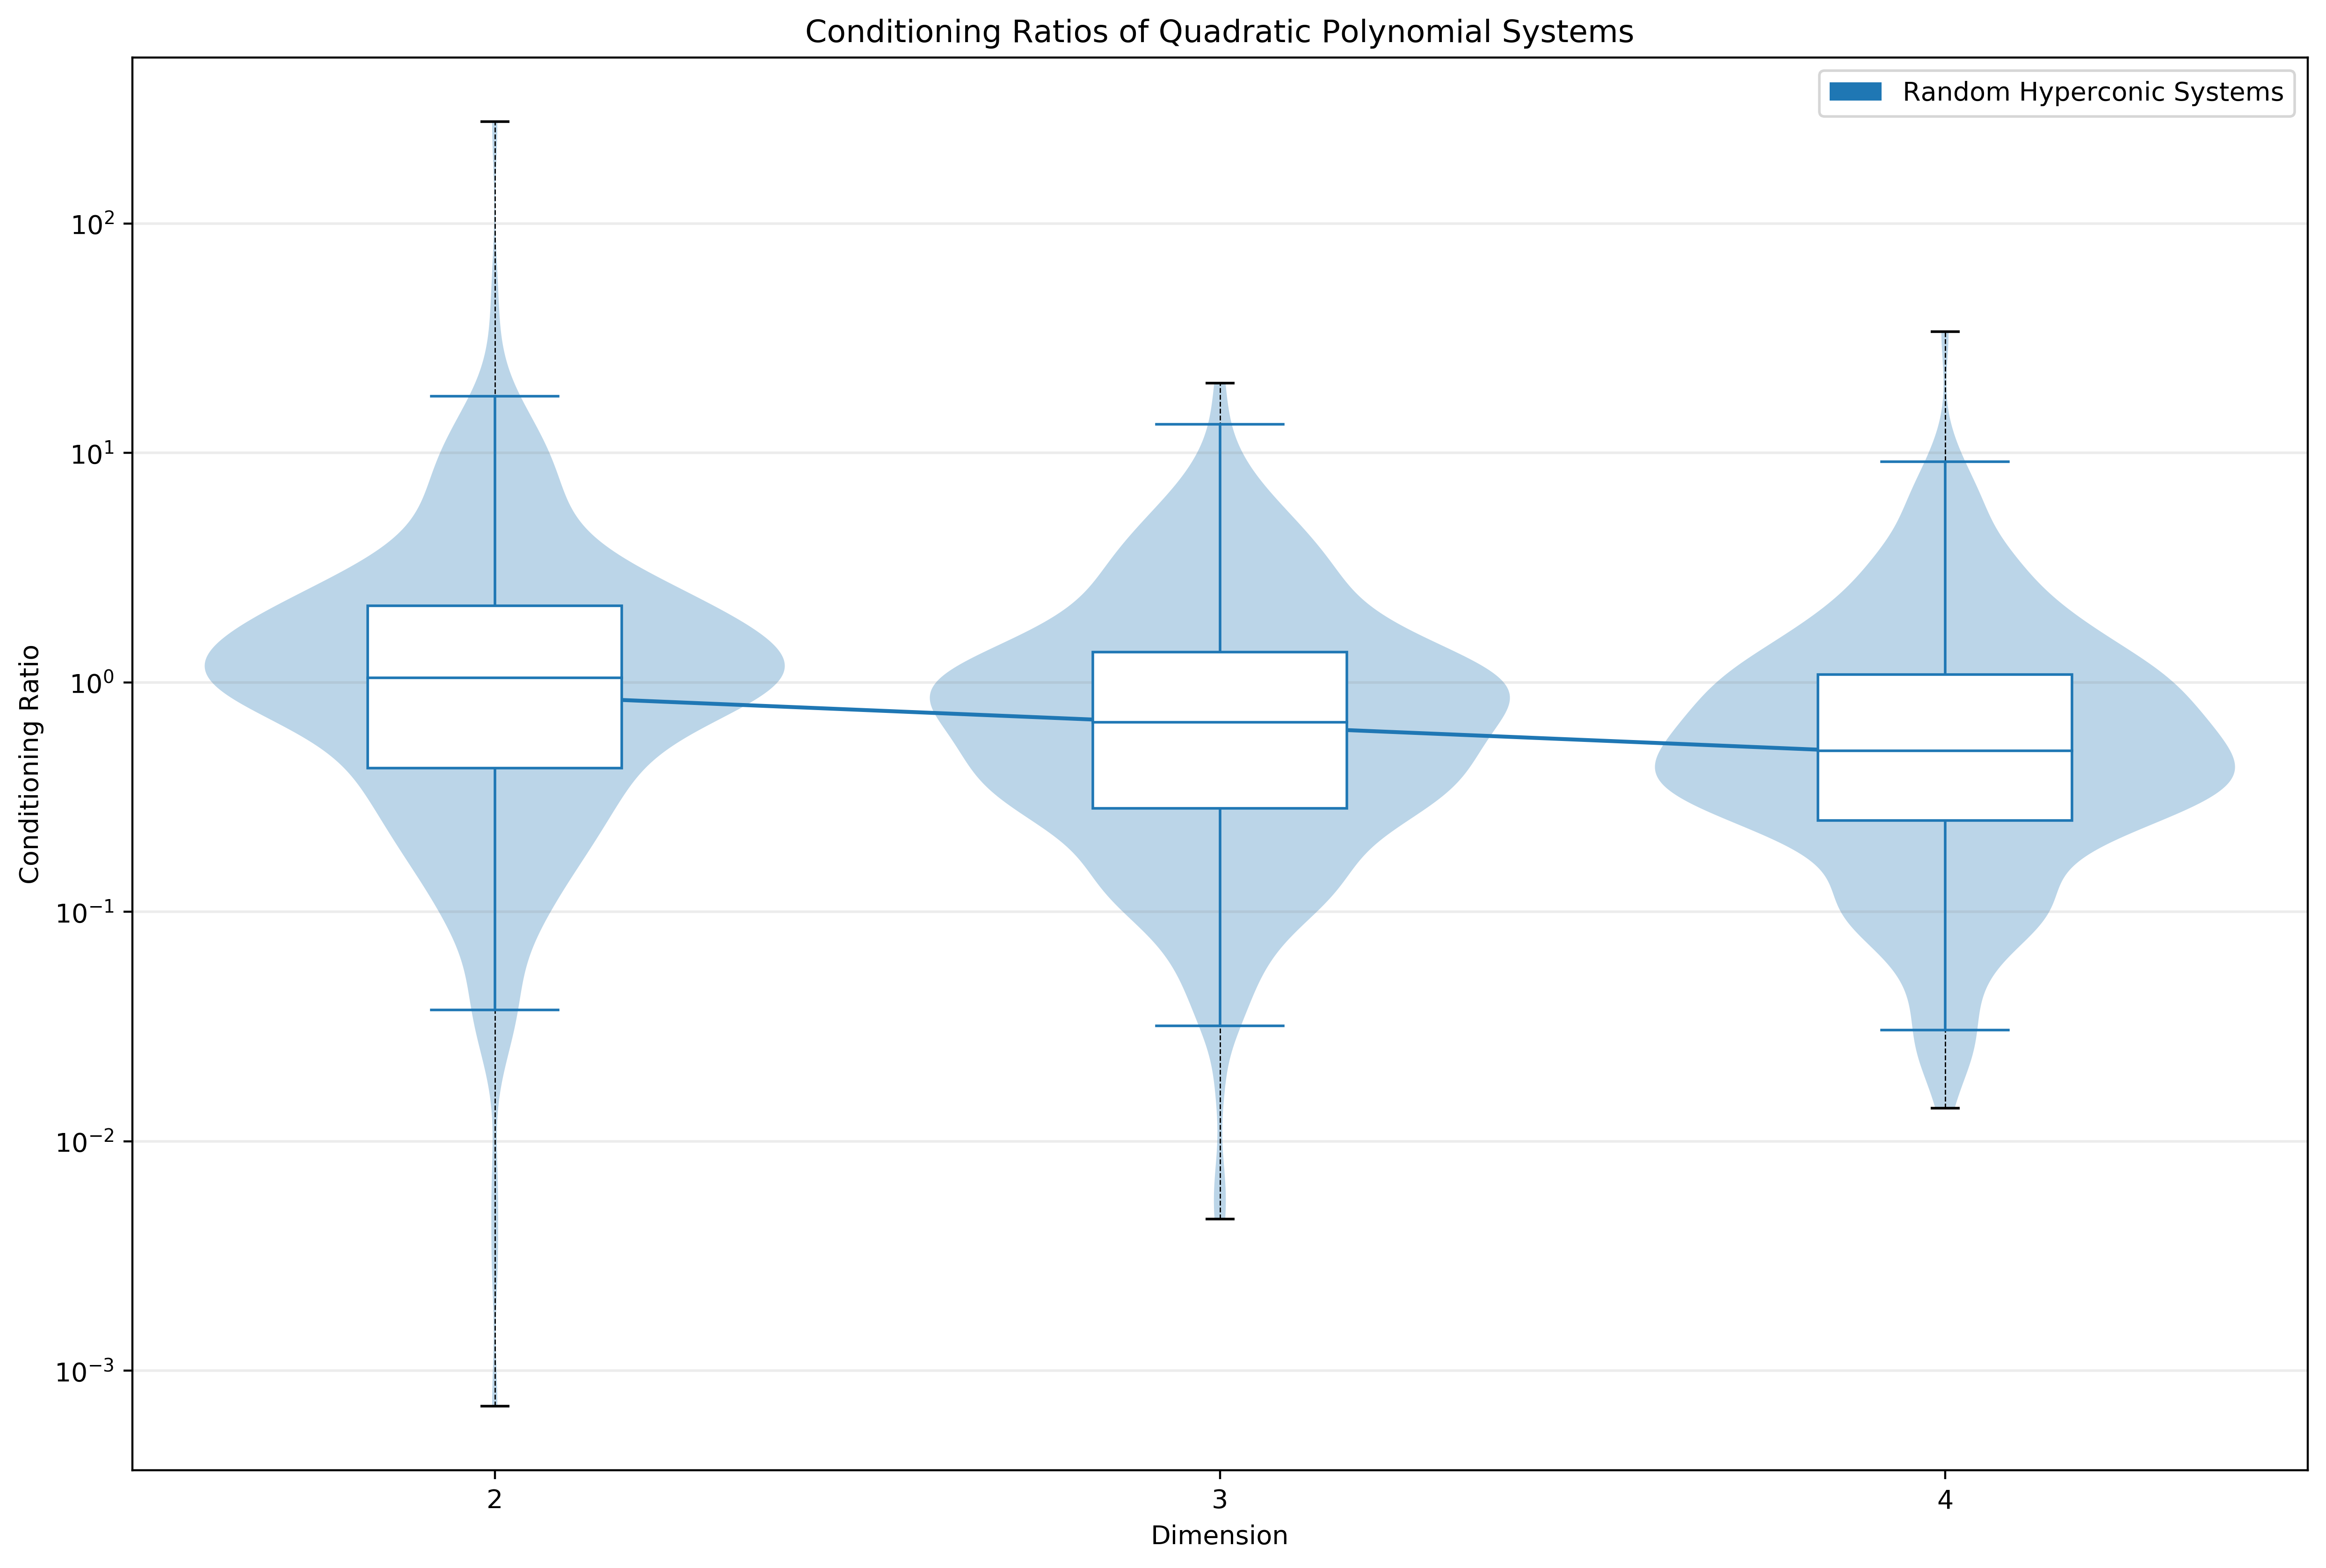

In [57]:
plot([rand1],
     [r'Random Hyperconic Systems'],
     figsize=(15,10), filename='random_hyperconic')

# trying to do extra precision

In [58]:
import mpmath as mp

In [59]:
mp.mp.prec = 86

In [60]:
print(mp.mp)

Mpmath settings:
  mp.prec = 86                [default: 53]
  mp.dps = 25                 [default: 15]
  mp.trap_complex = False     [default: False]


In [61]:
A = mp.randmatrix(4,4)
A

matrix(
[['0.4744668155578280044683981', '0.4222992982922995682116257', '0.3042966151522626415551212', '0.8245462434738230788845822'],
 ['0.5415930622956524648426798', '0.611110034545178555077711', '0.1064002003289712544092594', '0.6823921212576818427485277'],
 ['0.5470495519459327150624684', '0.2613526647567210195887307', '0.4644922804844736762452584', '0.2738890573516374966076514'],
 ['0.8945018525558118472576058', '0.8383478873351562824519868', '0.3567761452567943444978431', '0.3610677655795523950706329']])

In [62]:
idx = np.array([1,3])

In [63]:
U,S,Vh = mp.svd(mp.matrix(A))

In [64]:
U

matrix(
[['-0.4931630578252781589887556', '-0.6224194516820373915307919', '0.3221238252878311557696571', '0.5153838043111057064301282'],
 ['-0.499578440478206812338835', '-0.3684803546100342975633565', '-0.4524852251921658282207532', '-0.6402349030306151060261424'],
 ['-0.3578896118651790729561246', '0.3137395437817495726050394', '0.7617069871784940102961924', '-0.4396418884388436877346099'],
 ['-0.6157325766311017577836621', '0.6151290540219303767590046', '-0.3336102933786536652265766', '0.3622068650993767293017298']])

In [65]:
U[:,:2]

matrix(
[['-0.4931630578252781589887556', '-0.6224194516820373915307919'],
 ['-0.499578440478206812338835', '-0.3684803546100342975633565'],
 ['-0.3578896118651790729561246', '0.3137395437817495726050394'],
 ['-0.6157325766311017577836621', '0.6151290540219303767590046']])